# Chapter 4

Load libraries

In [1]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
library(cmdstanr)
library(rootSolve)

Warning message:
“package ‘MASS’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.2”

Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘purrr’ was built under R version 4.1.2”

Attaching package: ‘extraDistr’


The following object is masked from ‘package:purrr’:

    rdunif


Warning message:
“package ‘ggplot2’ was built under R version 4.1.2”
Warning message:
“package ‘loo’ was built under R version 4.1.2”
This is loo version 2.5.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) fo

ERROR: Error in library(cmdstanr): there is no package called ‘cmdstanr’


In [ ]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## Linear model

In [7]:
# load data
data("df_pupil")

In [14]:
df_pupil

subj trial load p_size   
1  701   1    2    1021.4086
2  701   2    1     951.4349
3  701   3    5    1063.9569
4  701   4    4     913.4871
5  701   5    0     602.6868
6  701   6    3     826.2199
7  701   7    0     463.8021
8  701   8    4     757.5521
9  701   9    2     732.9429
10 701  10    3     590.6491
11 701  11    5     878.7382
12 701  12    1     851.1801
13 701  13    4     772.2362
14 701  14    3     829.3486
15 701  15    0     455.4790
16 701  16    1     587.8027
17 701  17    2     713.0503
18 701  18    5     708.4417
19 701  19    1     707.6642
20 701  20    5     787.3699
21 701  21    2     566.9308
22 701  22    3     722.1417
23 701  23    0     540.0612
24 701  24    4     666.9247
25 701  25    2     698.2347
26 701  26    1     652.6698
27 701  27    3     575.6083
28 701  28    0     626.4327
29 701  29    5     572.8626
30 701  30    4     726.1621
31 701  31    5     751.8258
32 701  32    1     727.1855
33 701  33    2     624.9438
34 701  34    3     682.8066
35 701  35    4     687.1354
36 701  36    0     635.5361
37 701  37    3     613.6063
38 701  38    4     654.6275
39 701  39    1     556.5069
40 701  40    2     645.2146
41 701  41    0     600.5241

Let’s summarize our assumptions:

1. There is some average pupil size represented by α.
2. The increase of attentional load has a linear relationship with pupil size, determined by β.
3. There is some noise in this process, that is, variability around the true pupil size i.e., a scale, σ.
4. The noise is normally distributed.

#### Frequentist model

In [16]:
# frequentist model
f_model = lm(p_size ~ 1 + load, df_pupil)
f_model


Call:
lm(formula = p_size ~ 1 + load, data = df_pupil)

Coefficients:
(Intercept)         load  
     617.37        34.31  


In [25]:
# frequentist model - centered

m = mean(df_pupil$load)
df_pupil$centered_load = df_pupil$load - m

f_model_centered = lm(p_size ~ 1 + centered_load, df_pupil)
f_model_centered


Call:
lm(formula = p_size ~ 1 + centered_load, data = df_pupil)

Coefficients:
  (Intercept)  centered_load  
       701.06          34.31  


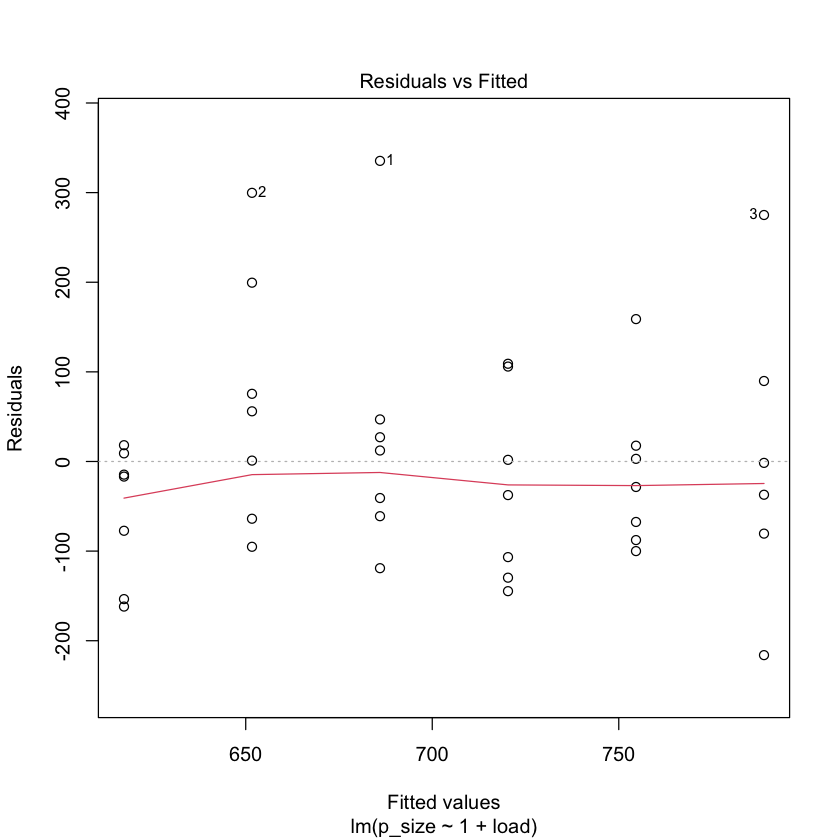

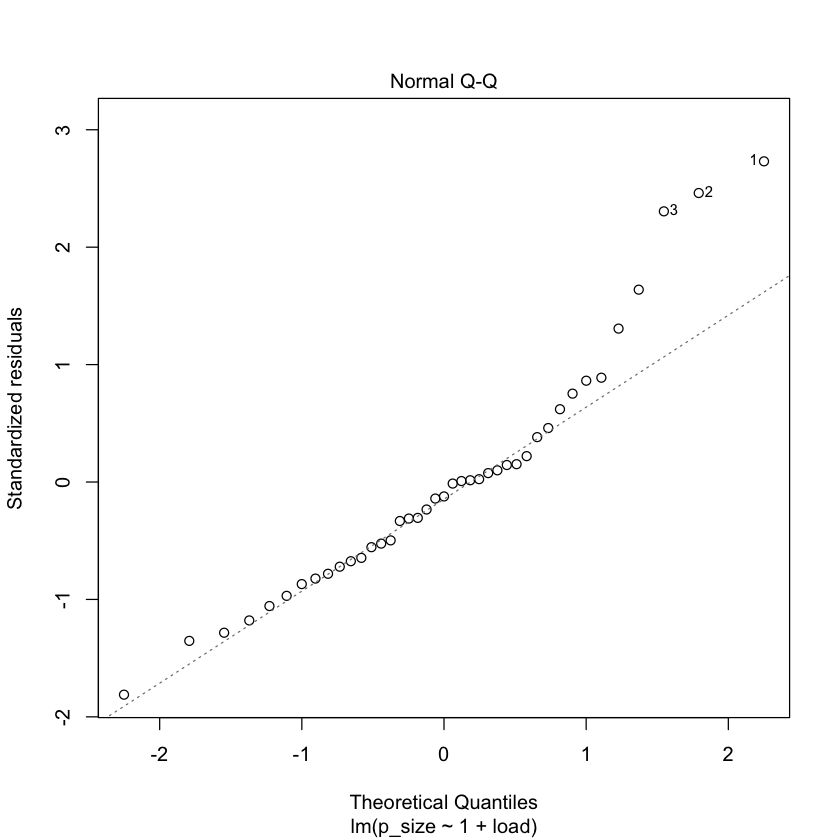

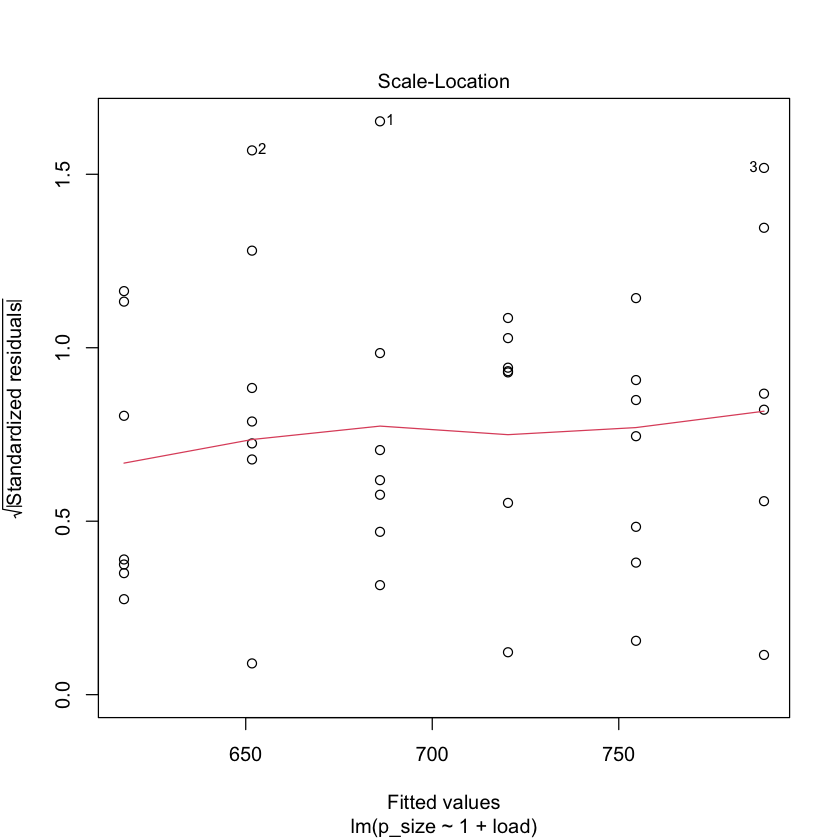

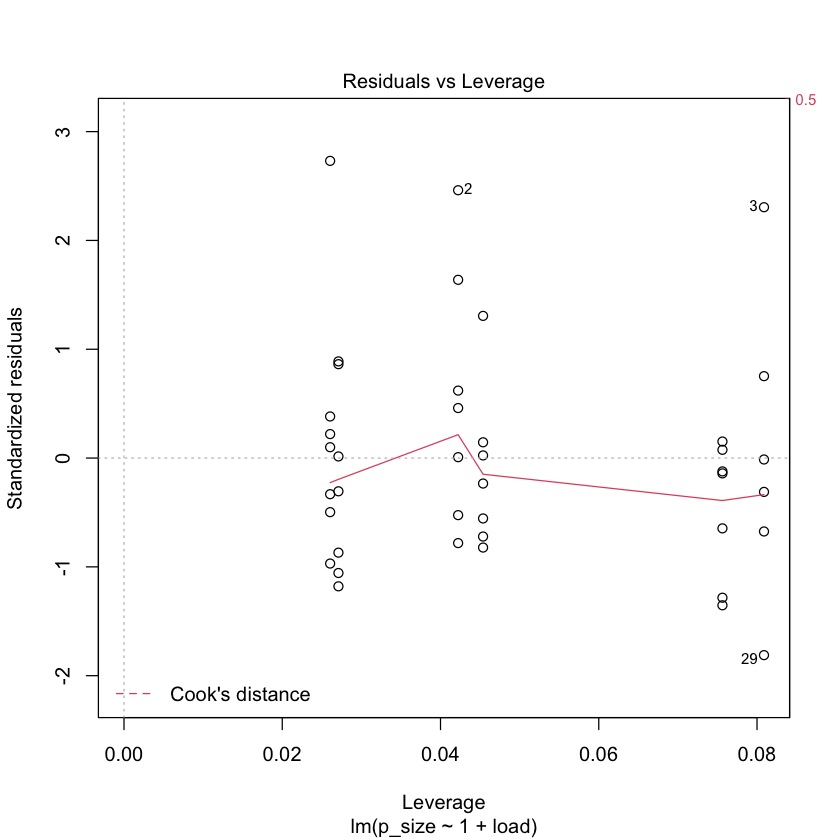

In [12]:
plot(f_model)

#### Bayesian model

In [26]:
# load pilot data for investigation of priors
data("df_pupil_pilot")

In [27]:
head(df_pupil_pilot)

time p_size
1 10   851.5 
2 20   853.0 
3 30   856.0 
4 40   859.0 
5 50   862.0 
6 60   864.5

### Priors

In [28]:
df_pupil_pilot$p_size %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  851.5   856.0   862.0   860.8   866.5   868.0 

With this information we can set a regularizing prior for α (mean). We center the prior around 1000 to be in the right order of magnitude. Since we don’t know how much pupil sizes are going to vary by load yet, we include a rather wide prior by defining it as a normal distribution and setting its standard deviation as 500.

In [30]:
# prior for mean within 95% CI
qnorm(c(.025, .975), mean = 1000, sd = 500)

[1]   20.01801 1979.98199

In [31]:
# prior for SD within 95% CI:
# it is surely larger than zero and 
# has to be in the order of magnitude of the pupil size with no load.

c(
  qtnorm(.025, mean = 0, sd = 1000, a = 0),
  qtnorm(.975, mean = 0, sd = 1000, a = 0)
)

[1]   31.33798 2241.40273

In [32]:
# prior for beta
# we expect them to be much smaller than 
# the pupil size (which we assume has mean 1000 units)


qnorm(c(.025, .975), mean = 0, sd = 100)

[1] -195.9964  195.9964

### Brm model

In [ ]:
# centering data

data("df_pupil")
(df_pupil <- df_pupil %>%
  mutate(c_load = load - mean(load)))

In [39]:
fit_pupil <- brm(p_size ~ 1 + c_load,
                 data = df_pupil,
                 family = gaussian(),
                 prior = c(
                     prior(normal(1000,500), class = Intercept),
                     prior(normal(0,1000), class = sigma),
                     prior(normal(0,100), class = b, coef = c_load) 
                 )
                )

Compiling Stan program...

Start sampling



In [40]:
fit_pupil

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: p_size ~ 1 + c_load 
   Data: df_pupil (Number of observations: 41) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   702.14     20.27   662.67   741.59 1.00     3305     2704
c_load       33.92     11.82    11.15    57.28 1.00     3851     2643

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma   129.11     15.53   103.45   163.33 1.00     3238     2542

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

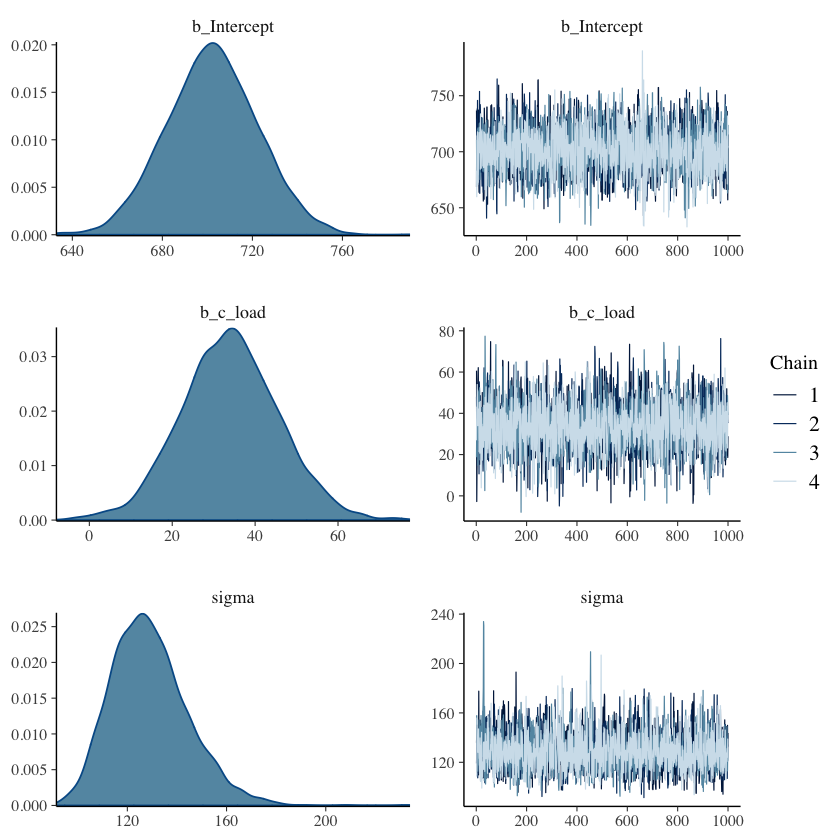

In [41]:
plot(fit_pupil)

In [42]:
# If we want to determine how likely it is that the pupil size increased rather than decreased, 
# we can examine the proportion of samples above zero.

mean(as_draws_df(fit_pupil)$b_c_load > 0)

[1] 0.99675

### Posterior predictive checks

This high probability does not mean that the effect of load is non-zero. It means instead that it’s much more likely that the effect is positive rather than negative.

**In order to claim that the effect is likely to be non-zero, we would have to compare the model with an alternative model in which the model assumes that the effect of load is 0. We’ll come back to this issue in the model comparison chapter 14.**

The plot shows 100 predicted distributions with the label y_rep, the distribution of pupil size data in black with the label y, and the observed pupil sizes in black dots for the five levels of attentional load.

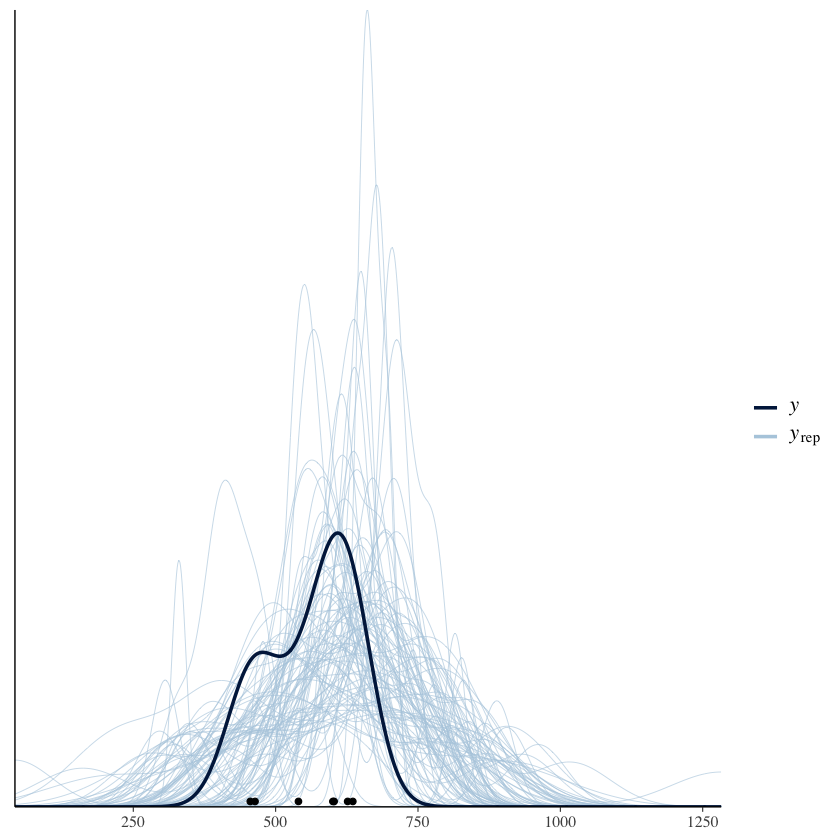

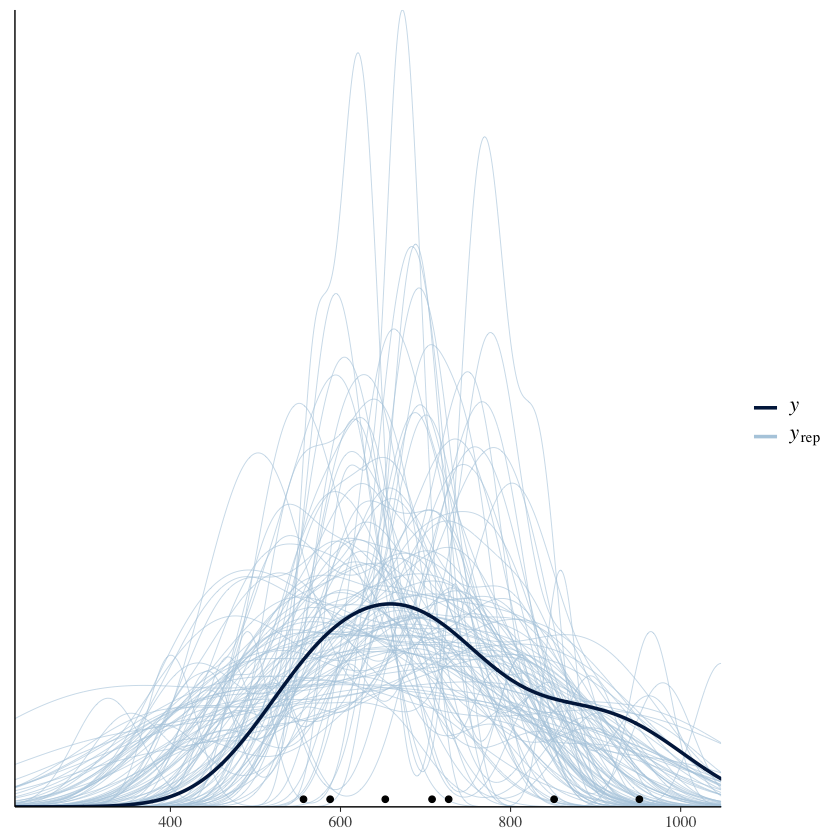

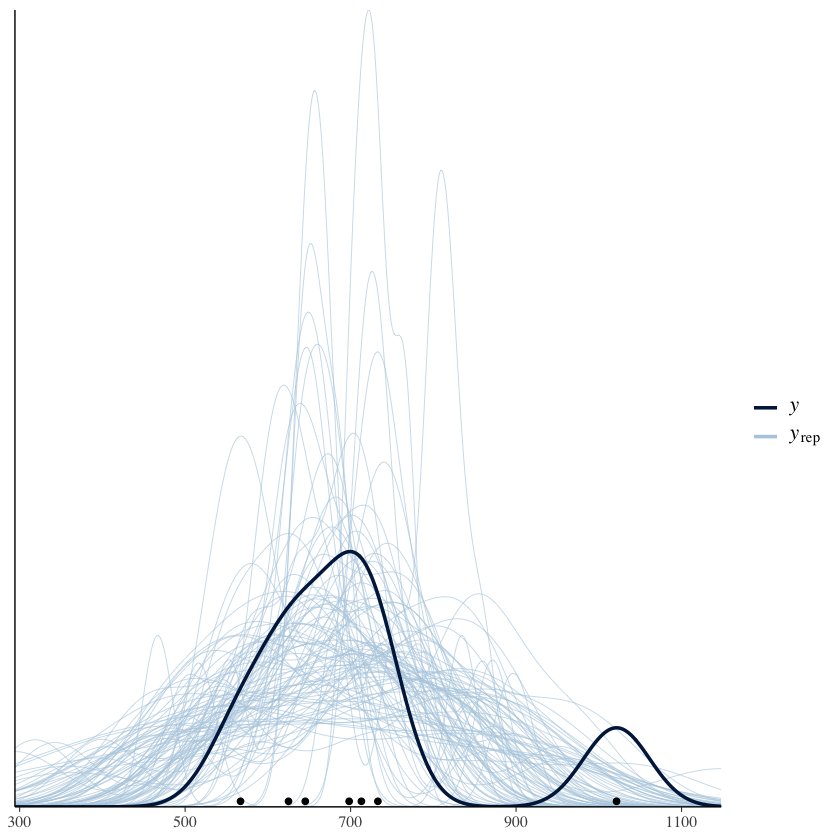

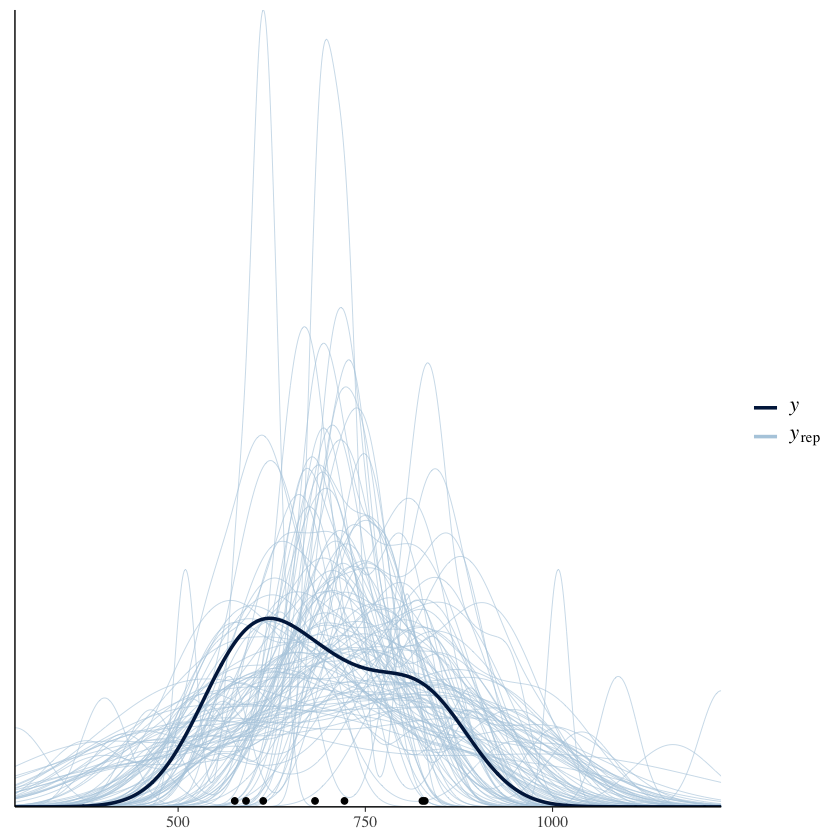

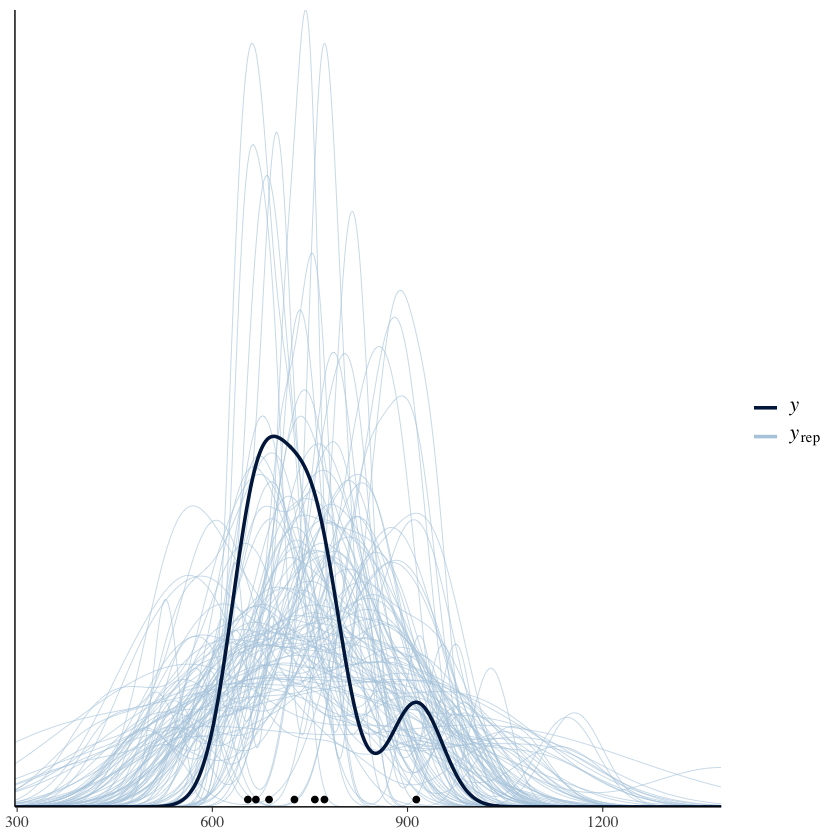

In [51]:
for (i in 0:4){
    df_sub_pupil = filter(df_pupil, load==i)
    plt = pp_check(
        fit_pupil, 
        ndraws = 100, 
        type = "dens_overlay",
        newdata = df_sub_pupil
    ) + geom_point(data = df_sub_pupil, aes(x = p_size, y = 0.0001))
    
    print(plt)
}

We look instead at the distribution of a summary statistic, such as mean pupil size by load:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



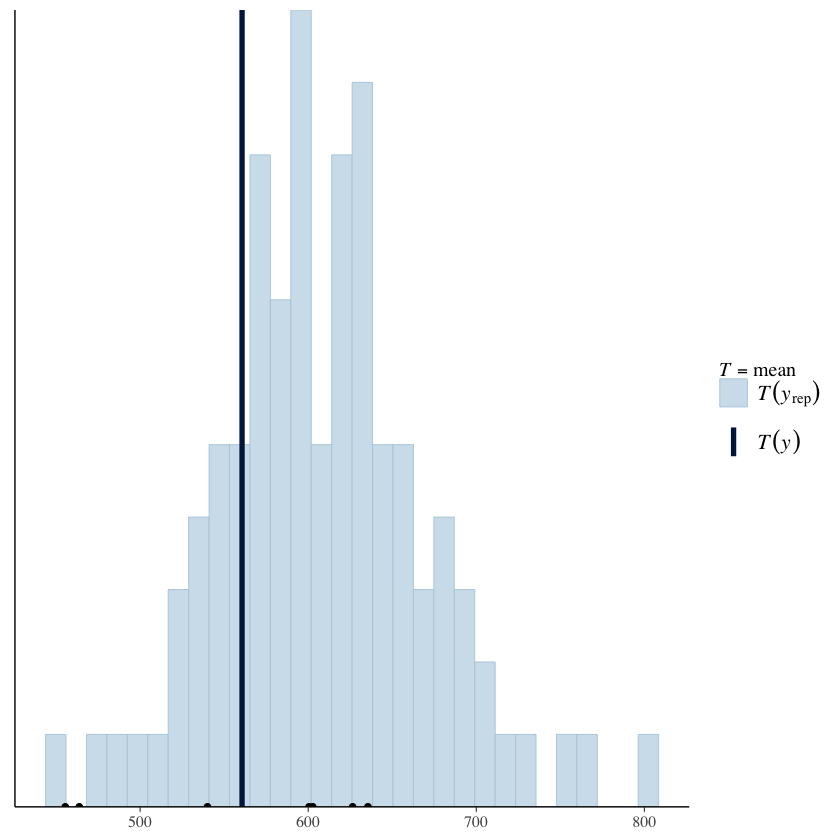

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



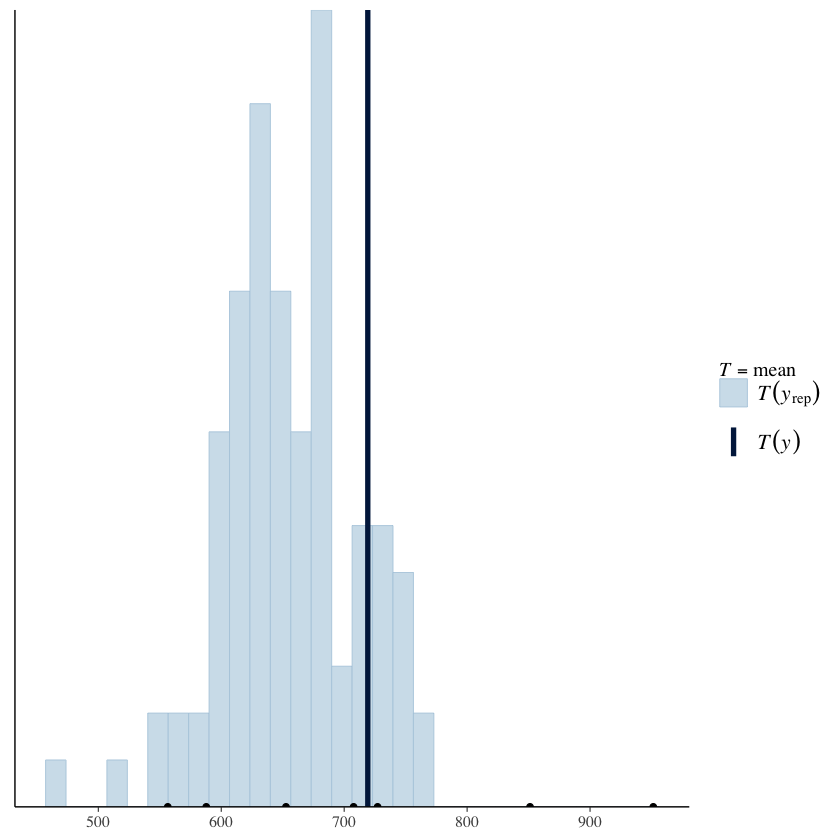

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



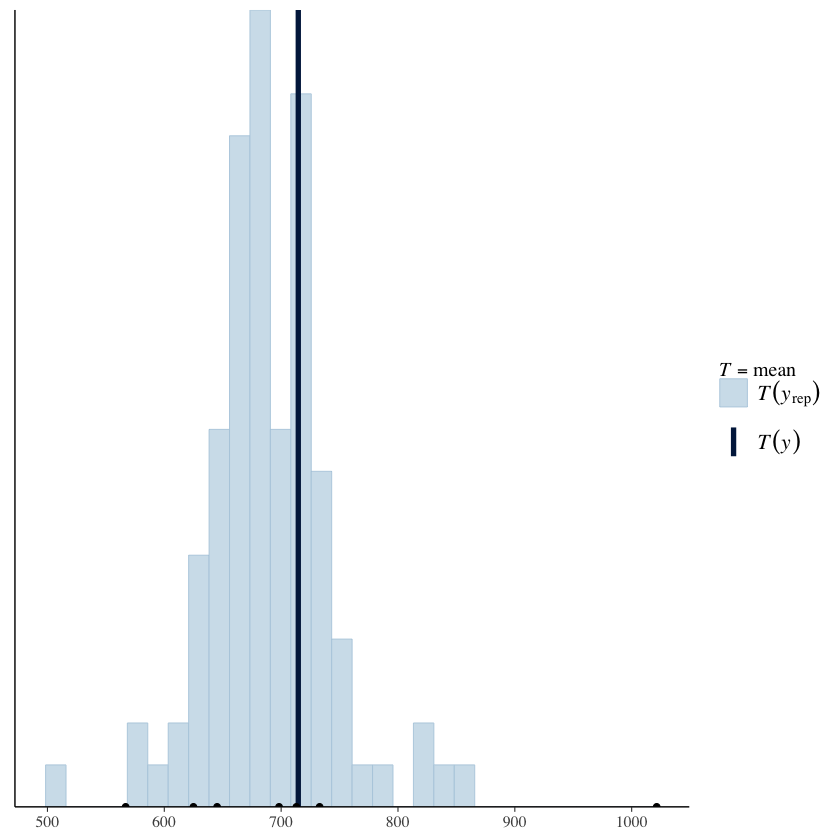

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



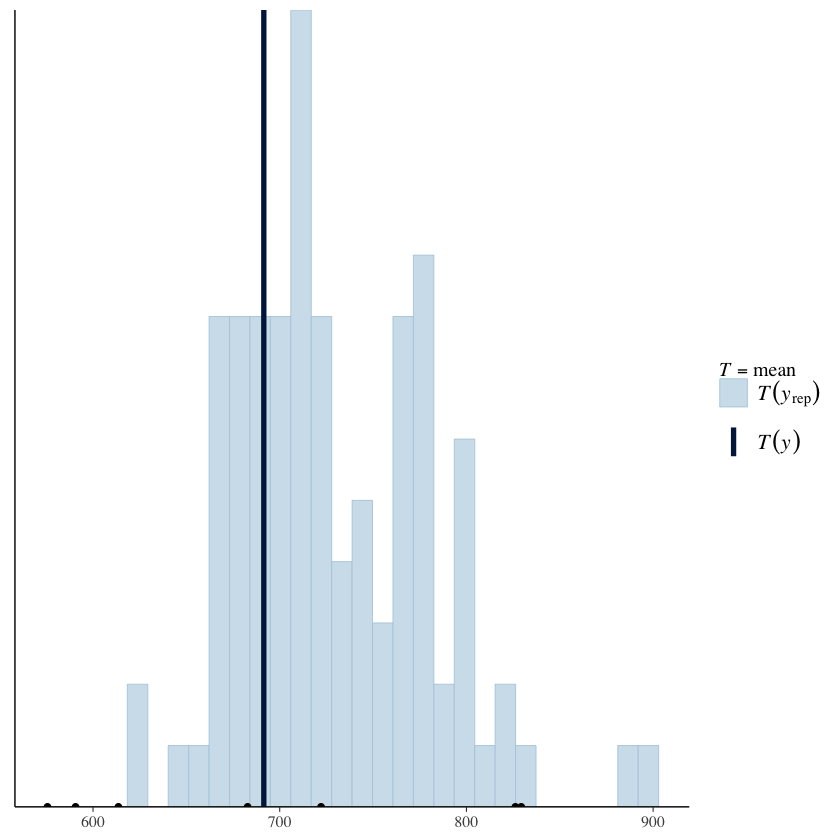

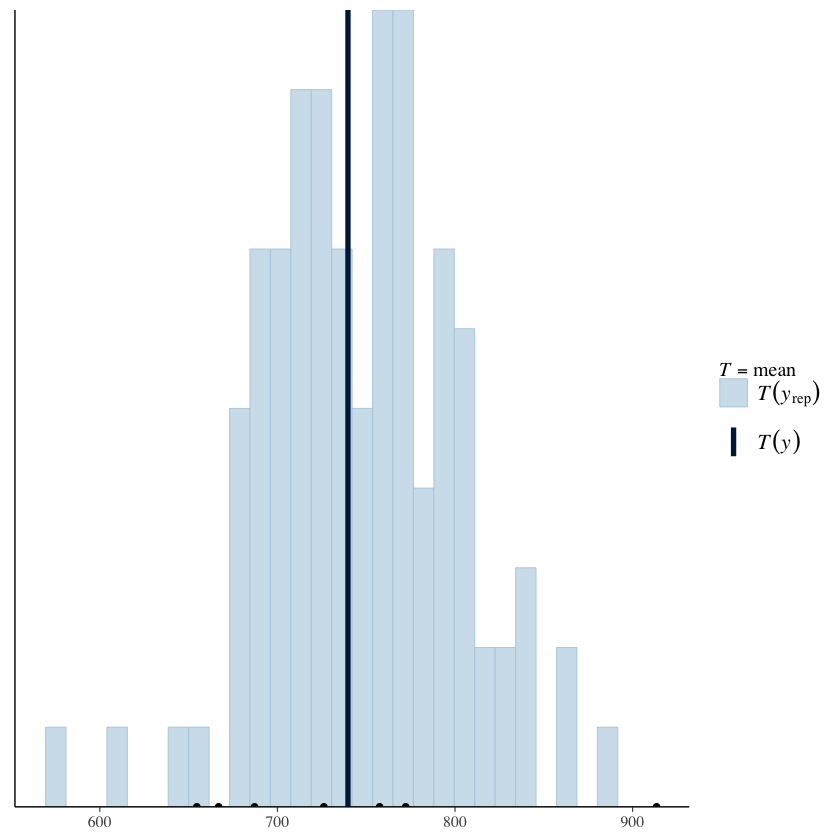

In [52]:
for (i in 0:4){
    df_sub_pupil = filter(df_pupil, load==i)
    plt = pp_check(
        fit_pupil, 
        ndraws = 100, 
        type = "stat",
        newdata = df_sub_pupil,
        stat="mean"
    ) + geom_point(data = df_sub_pupil, aes(x = p_size, y = 0.0001))
    
    print(plt)
}

Data do not clearly indicate that there is a linear relationsip between load and pupil size - rather that there is the difference between no load and *some* load.

## Log-normal distribution

### Priors

In [2]:
# centered data

df_spacebar <- df_spacebar %>%
  mutate(c_trial = trial - mean(trial))

The objective of the prior predictive checks is to calibrate the prior of β to obtain a plausible range of differences.

In [ ]:
# prior predictive dist

df_spacebar_ref <- df_spacebar %>%
  mutate(rt = runif(n(), 0, 10000))

fit_prior_press_trial <- brm(rt ~ 1 + c_trial,
  data = df_spacebar_ref,
  family = lognormal(),
  prior = c(
    prior(normal(6, 1.5), class = Intercept),
    prior(normal(0, 1), class = sigma),
    prior(normal(0, 1), class = b, coef = c_trial)
  ),
  sample_prior = "only",
  # control = list(adapt_delta = .9),
  iter = 3000
)

In [4]:
fit_prior_press_trial

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ 1 + c_trial 
   Data: df_spacebar_ref (Number of observations: 361) 
  Draws: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup draws = 6000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     6.02      1.52     3.05     9.02 1.00     3717     3326
c_trial       0.02      0.98    -1.84     2.00 1.00     4137     3966

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.80      0.60     0.04     2.26 1.00     2554     1611

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [18]:
# we define stats of response-trial effect as median, because mean 
# is linked to SD, so our prior on SD strongly affect our results

# to fit prior for B, we need define some stat (independent from other variables) 
# that allow us to check whether our defined ranges are appriopriate

median_diff <- function(x) {
  median(x - lag(x), na.rm = TRUE)
}

Using all posterior draws for ppc type 'stat' by default.



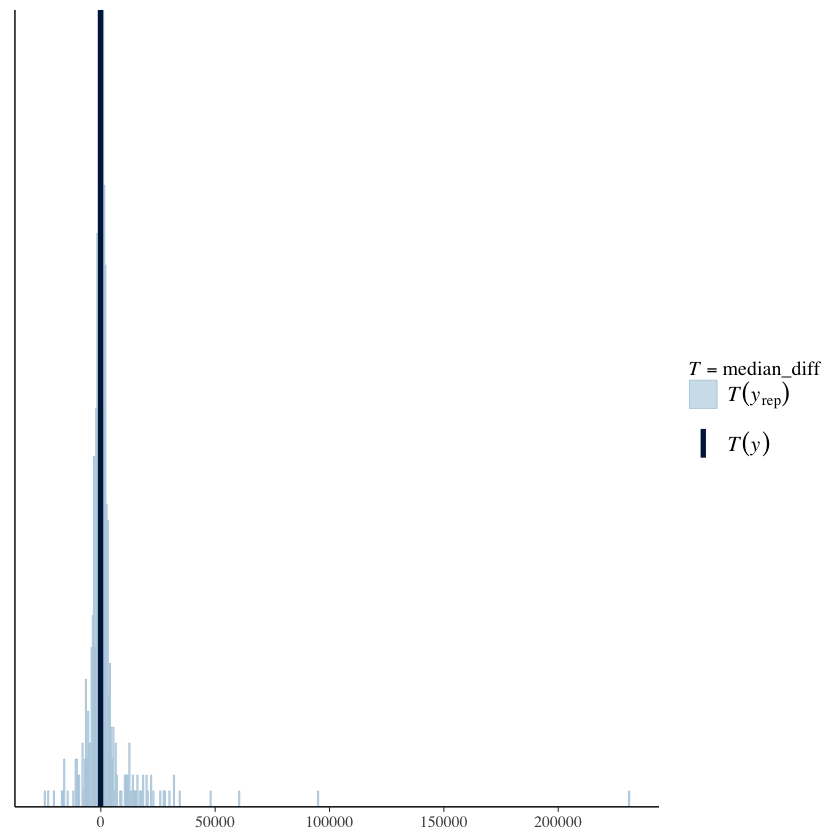

In [23]:
# Prior predictive distribution of the median effect of the model defined above 
# with β disributed normally (0,1)

pp_check(
        fit_prior_press_trial, 
        type = "stat",
        stat="median_diff",
        binwidth = 500
    ) + coord_cartesian(ylim = c(0, 50))

In [ ]:
# we repeat experiment with different (narrower) β prior

fit_prior_press_trial_2 <- brm(rt ~ 1 + c_trial,
  data = df_spacebar_ref,
  family = lognormal(),
  prior = c(
    prior(normal(6, 1.5), class = Intercept),
    prior(normal(0, 1), class = sigma),
    prior(normal(0, 0.01), class = b, coef = c_trial)
  ),
  sample_prior = "only",
  # control = list(adapt_delta = .9),
  iter = 3000
)

Using all posterior draws for ppc type 'stat' by default.



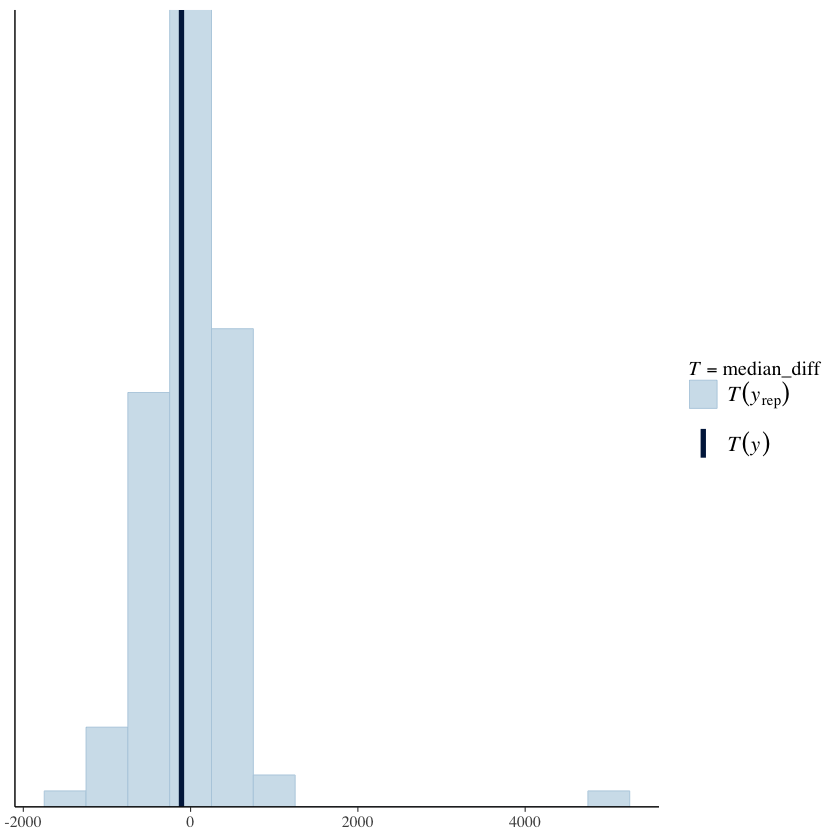

In [25]:
pp_check(
        fit_prior_press_trial_2, 
        type = "stat",
        stat="median_diff",
        binwidth = 500
    ) + coord_cartesian(ylim = c(0, 50))

Seems better!

### Brm models

In [ ]:
fit_press_trial <- brm(rt ~ 1 + c_trial,
  data = df_spacebar,
  family = lognormal(),
  prior = c(
    prior(normal(6, 1.5), class = Intercept),
    prior(normal(0, 1), class = sigma),
    prior(normal(0, 0.01), class = b, coef = c_trial)
  ),
)

In [28]:
posterior_summary(fit_press_trial)[, c("Estimate", "Q2.5", "Q97.5")]

Estimate      Q2.5          Q97.5        
b_Intercept  5.118377e+00  5.105191e+00  5.131352e+00
b_c_trial    5.232767e-04  4.005902e-04  6.424753e-04
sigma        1.232580e-01  1.146790e-01  1.323877e-01
lprior       1.954307e+00  1.948903e+00  1.959452e+00
lp__        -1.603709e+03 -1.606996e+03 -1.602309e+03

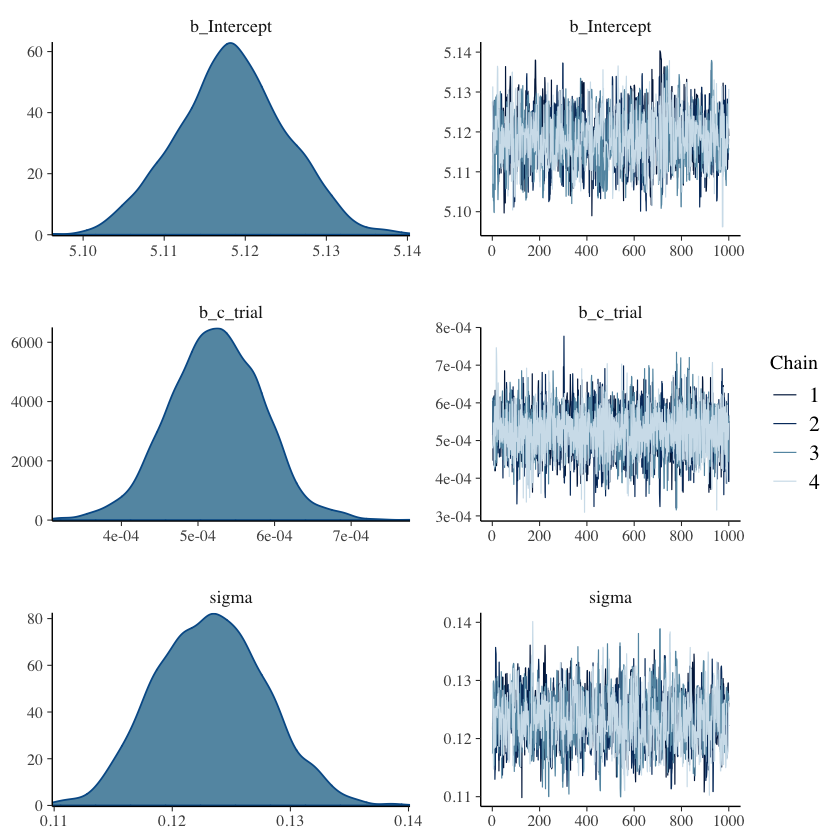

In [29]:
plot(fit_press_trial)

As shown above, the first step is to summarize the posteriors in a table or graphically (or both). If the research relates to the effect estimated by the model, the posterior of $\beta$ can be summarized in the following way: $\hat{\beta} = 0.00052,  95\%  CrI =[0.0004,0.00065]$

The effect is easier to interpret in milliseconds. We can transform the estimates back to the millisecond scale from the log scale, but we need to take into account that the scale is not linear, and that the effect between two button presses will differ depending on where we are in the experiment.

Remember - estimates of median (!)

Difference between mid trial and the previous one:

In [39]:
# alpha to są z defaulu średnie scentrowane na trialu - 
# czyli średnie dla środkowego trialu
alpha_samples <- as_draws_df(fit_press_trial)$b_Intercept 
beta_samples <- as_draws_df(fit_press_trial)$b_c_trial

effect_middle_ms <- 
    # value under mid trial
    exp(alpha_samples) -
    # value under mid trial - 1
    exp(alpha_samples + (-1) * beta_samples)

In [36]:
c(
  mean = mean(effect_middle_ms),
  quantile(effect_middle_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.08740063 0.06691397 0.10728269

We will obtain different estimate if we consider the difference between the second and the first trial:

In [49]:
first_trial = min(df_spacebar$c_trial) # get number of first trial in centered trials values
second_trial = min(df_spacebar$c_trial) + 1 # get number of second trial in centered trials values

effect_beginning_ms <- 
    exp(alpha_samples + second_trial * beta_samples) - 
    exp(alpha_samples + first_trial * beta_samples)

## ms effect from first to second trial:
c(
  mean = mean(effect_beginning_ms),
  quantile(effect_beginning_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.07948872 0.06227246 0.09565138

Different way with function $fitted()$ - estimates of mean (!):

In [50]:
# define data for which we want to obtain estimates
newdata_1 <- data.frame(c_trial = c(first_trial, second_trial))

In [52]:
beginning <- fitted(
    fit_press_trial,
    newdata = newdata_1,
    summary = FALSE)

# The first column contains the posterior samples transformed into milliseconds of the first trial, 
# and the second column of the second trial.
head(beginning)

[,1]     [,2]    
[1,] 152.3376 152.4298
[2,] 150.7259 150.8160
[3,] 156.5095 156.5796
[4,] 150.8660 150.9542
[5,] 150.4386 150.5252
[6,] 153.8769 153.9595

In [54]:
# calculate the difference between posterior samples of trials

effect_beginning_ms <- beginning[, 2] - beginning[,1]

c(
  mean = mean(effect_beginning_ms),
  quantile(effect_beginning_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.08009571 0.06269145 0.09645990

Clearly, there is a slow down - no matter whether we investigate effect on the beginning, or in the middle of experiment

### Posterior predictive checks

As the effect is small, we investige effect between first and the 100 trial

In [56]:
median100_diff <- function(x) median(x - lag(x,100), na.rm = TRUE)

Using all posterior draws for ppc type 'stat' by default.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



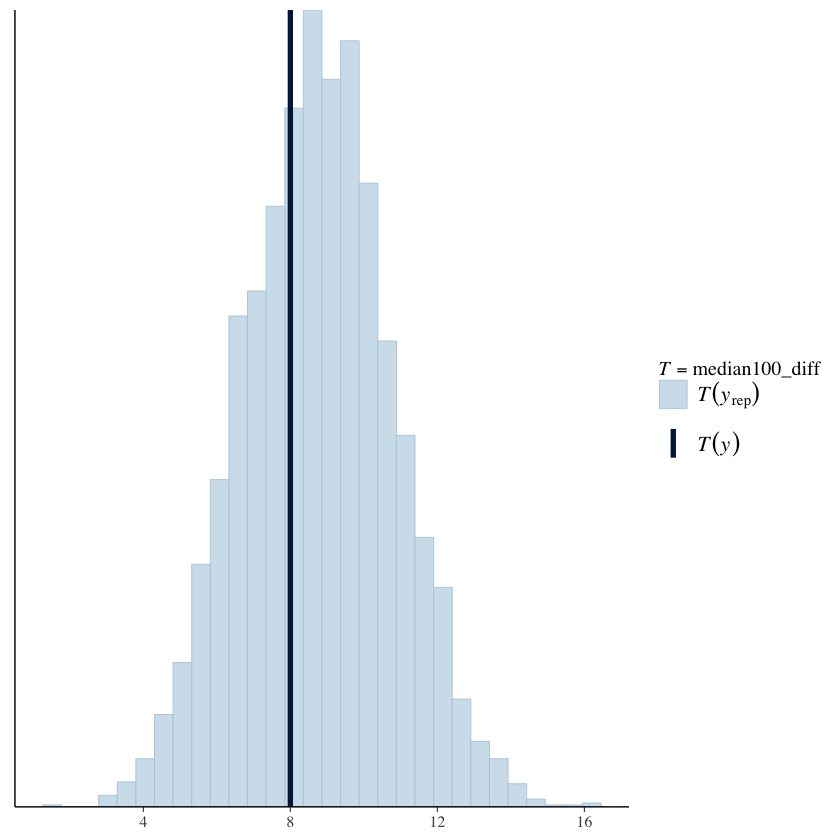

In [58]:
pp_check(
        fit_press_trial, 
        type = "stat",
        stat="median100_diff",
    )

Excellent! We can conclude that model predictions for differences in response trials between trials are reasonable.

## Logistic regression

Load data

In [80]:
data("df_recall")

# center data - set_size
df_recall <- df_recall %>%
  mutate(c_set_size = set_size - mean(set_size))

# Set sizes in the data set:
df_recall$set_size %>%
  unique() %>% sort()

[1] 2 4 6 8

In [ ]:
df_recall

In [82]:
# Trials by set size
df_recall %>%
  group_by(set_size) %>%
  count()

set_size n 
1 2        23
2 4        23
3 6        23
4 8        23

We want to model the trial-by-trial accuracy and examine whether the probability of recalling a word is related to the number of words in the set that the subject needs to remember.

### Priors

Now we need to set priors for α and β.

#### Alpha

Given that we centered our predictor, the intercept, α, represents the log-odds of correctly recalling one word in a random position for the average set size of five.


The prior for α will depend on how difficult the recall task is. If we are not sure, we could assume that the probability of recalling a word for an average set size, α, is centered in .5 (a 50/50 chance) with a great deal of uncertainty. 0.5 is in log space 0.

Uncertainty (SD) : We could look at Figure 4.14, and decide on a standard deviation of 4 in a normal distribution centered in zero.

So let's try (0,4)

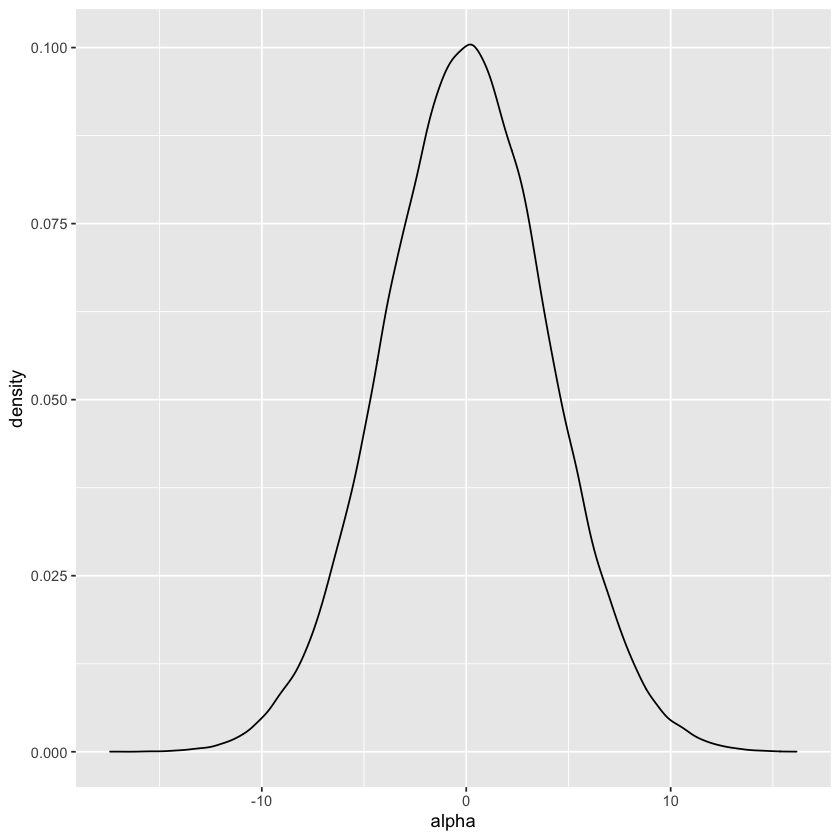

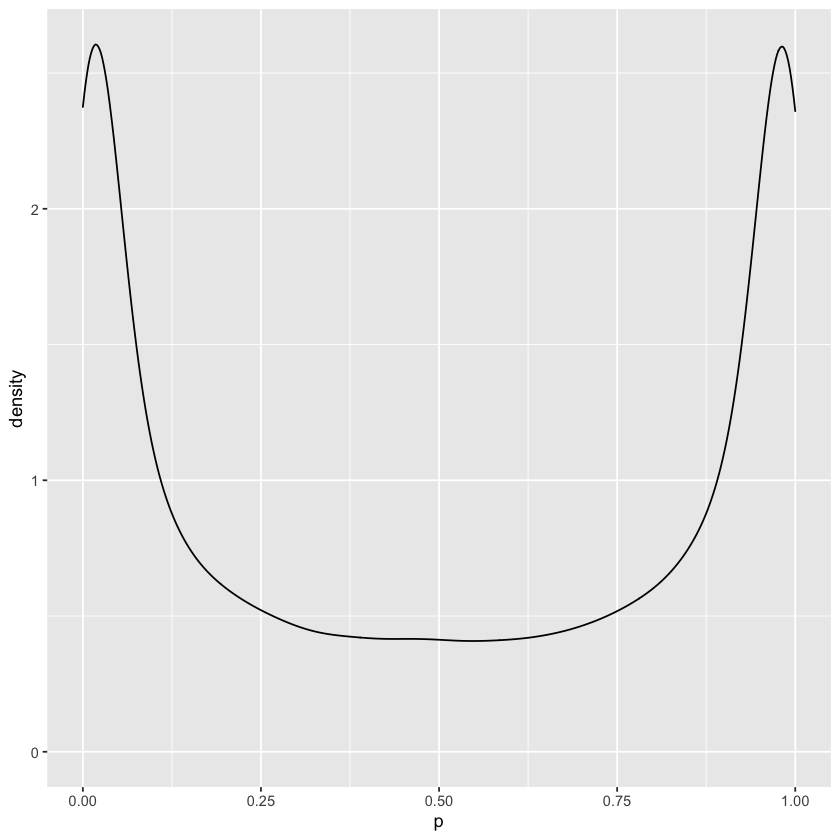

In [71]:
samples_logodds <- tibble(alpha = rnorm(100000, 0, 4)) # logodds are normally distrubuted
samples_prob <- tibble(p = plogis(rnorm(100000, 0, 4))) #  inverse logit of logodds to get real samples

ggplot(samples_logodds, aes(alpha)) +
  geom_density()

ggplot(samples_prob, aes(p)) +
  geom_density()

We can see, that our real data (second plot) are very weird - extreme values are most probable - it in not a distribution we want. Let's try again with narrower SD.

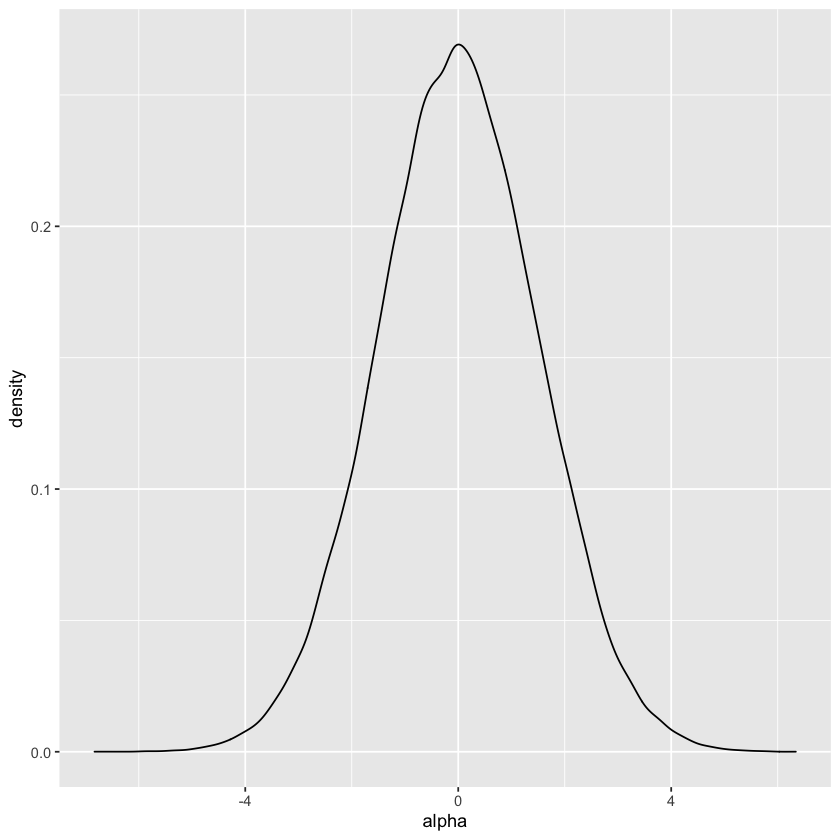

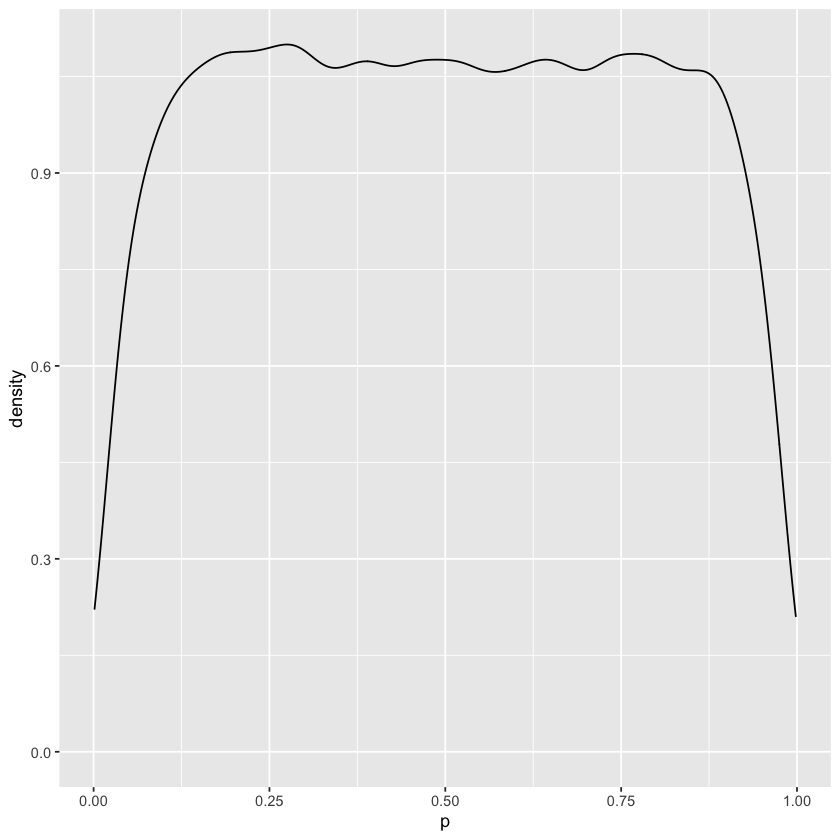

In [70]:
samples_logodds <- tibble(alpha = rnorm(100000, 0, 1.5)) # logodds are normally distrubuted
samples_prob <- tibble(p = plogis(rnorm(100000, 0, 1.5))) #  inverse logit of logodds to get real samples

ggplot(samples_logodds, aes(alpha)) +
  geom_density()

ggplot(samples_prob, aes(p)) +
  geom_density()

Seems very good!

#### Beta

We need to decide now on the prior for β, the effect in log-odds of increasing the set size. We could choose a normal distribution centered on zero, reflecting our lack of any commitment regarding the direction of the effect.

In [103]:
logistic_model_pred <- function(alpha_samples,
                                beta_samples,
                                set_size,
                                N_obs) {
  map2_dfr(alpha_samples, beta_samples,
    function(alpha, beta) {
      tibble(
        set_size = set_size,
        # center size:
        c_set_size = set_size - mean(set_size),
        # change the likelihood:
        # Notice the use of a link function
        # for alpha and beta
        theta = plogis(alpha + c_set_size * beta),
        correct_pred = rbernoulli(N_obs, p = theta)
      )
    },
    .id = "iter"
  ) %>%
    # .id is always a string and needs
    # to be converted to a number
    mutate(iter = as.numeric(iter))
}

In [104]:
N_obs <- 800
set_size <- rep(c(2, 4, 6, 8), 200)

In [107]:
alpha_samples <- rnorm(1000, 0, 1.5)
sds_beta <- c(1, 0.5, 0.1, 0.01, 0.001)

prior_pred <- map_dfr(sds_beta, function(sd) {
  beta_samples <- rnorm(1000, 0, sd)
  logistic_model_pred(
    alpha_samples = alpha_samples,
    beta_samples = beta_samples,
    set_size = set_size,
    N_obs = N_obs
  ) %>%
    mutate(prior_beta_sd = sd)
})

In [108]:
mean_accuracy <-
  prior_pred %>%
  group_by(prior_beta_sd, iter, set_size) %>%
  summarize(accuracy = mean(correct_pred)) %>%
  mutate(prior = paste0("Normal(0, ", prior_beta_sd, ")"))

`summarise()` has grouped output by 'prior_beta_sd', 'iter'. You can override using the `.groups` argument.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



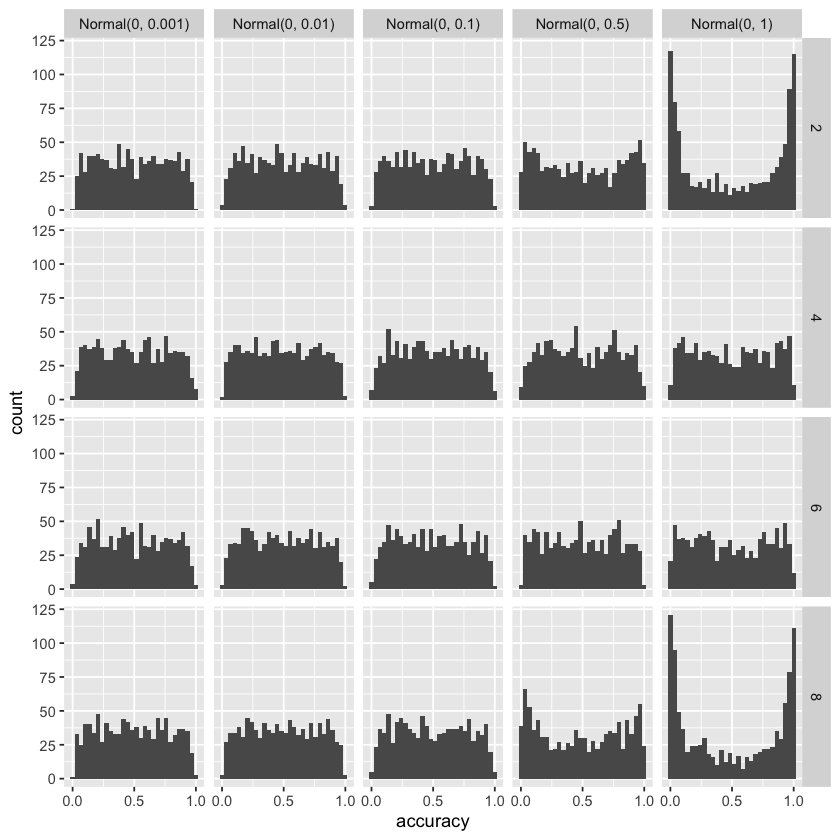

In [109]:
mean_accuracy %>%
  ggplot(aes(accuracy)) +
  geom_histogram() +
  facet_grid(set_size ~ prior) +
  scale_x_continuous(breaks = c(0, .5, 1))

In [110]:
diff_accuracy <- mean_accuracy %>%
  arrange(set_size) %>%
  group_by(iter, prior_beta_sd) %>%
  mutate(diff_accuracy = accuracy - lag(accuracy)) %>%
  mutate(diffsize = paste(set_size, "-", lag(set_size))) %>%
  filter(set_size > 2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



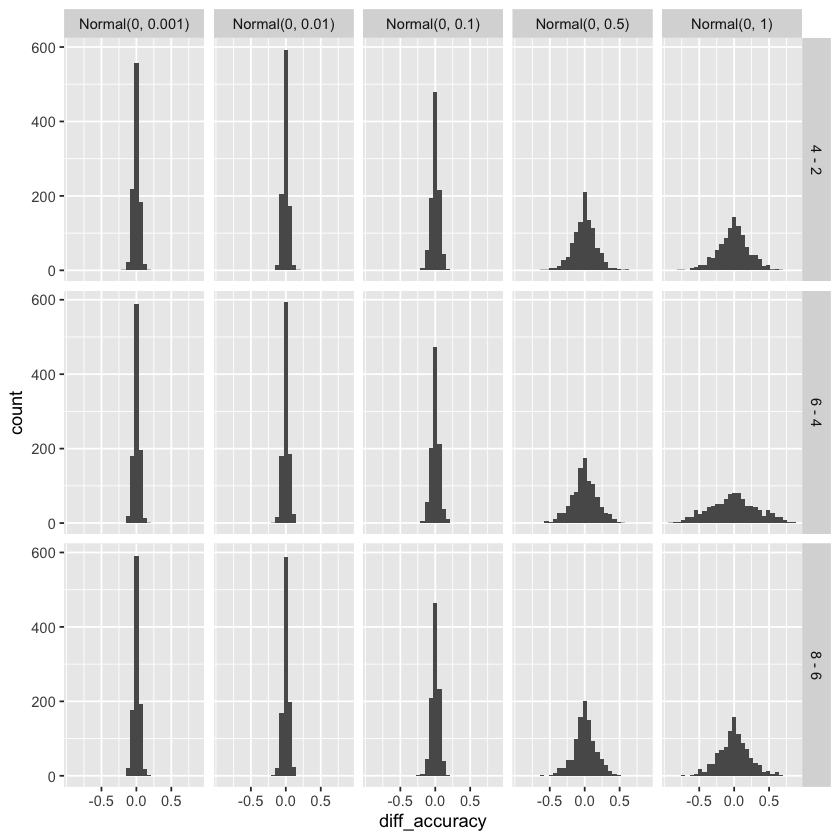

In [111]:
diff_accuracy %>%
  ggplot(aes(diff_accuracy)) +
  geom_histogram() +
  facet_grid(diffsize ~ prior) +
  scale_x_continuous(breaks = c(-.5, 0, .5))

... and we choose prior $Normal(0,0.1)$

### Brm models

In [ ]:
fit_recall <- brm(correct ~ 1 + c_set_size,
  data = df_recall,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .1), class = b, coef = c_set_size)
  )
)

In [113]:
posterior_summary(fit_recall)[, c("Estimate", "Q2.5", "Q97.5")]

Estimate    Q2.5       Q97.5       
b_Intercept    1.9178112   1.352438   2.57654928
b_c_set_size  -0.1830984  -0.351315  -0.02408849
lprior        -2.7996315  -7.000059  -0.65585972
lp__         -34.8355100 -37.639763 -33.82321179

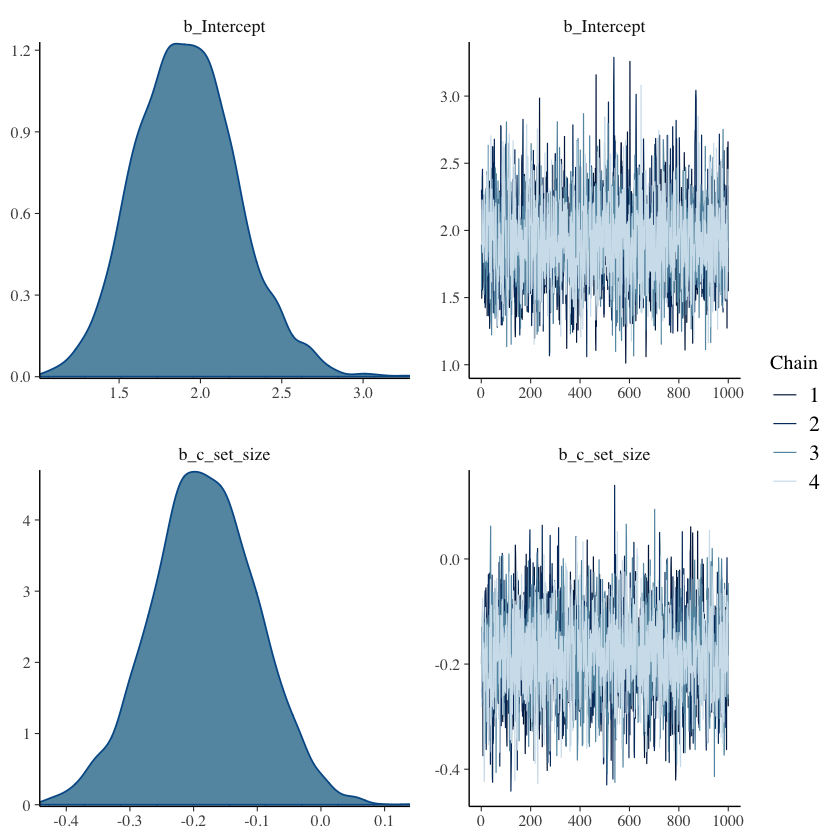

In [114]:
plot(fit_recall)

Average accurecy for the task:

In [121]:
alpha_samples <- as_draws_df(fit_recall)$b_Intercept
av_accuracy <- plogis(alpha_samples)
c(mean = mean(av_accuracy), quantile(av_accuracy, c(0.025, 0.975)))

mean      2.5%     97.5% 
0.8679129 0.7945279 0.9293370

As before, to transform the effect of our manipulation to an easier to interpret scale (i.e., proportion), we need to take into account that the scale is not linear, and that the effect of increasing the set size depends on the average accuracy, and the set size that we start from.

We can do the following calculation, similar to what we did for the trial effects experiment, to find out the decrease in accuracy in proportions or probability scale:

In [122]:
beta_samples <- as_draws_df(fit_recall)$b_c_set_size

effect_middle <- plogis(alpha_samples + 0*beta_samples) -
  plogis(alpha_samples + (-1)*beta_samples)


c(mean = mean(effect_middle),
  quantile(effect_middle, c(0.025, 0.975)))

mean         2.5%        97.5% 
-0.018925340 -0.037128132 -0.002355461

Interpretation: Notice the interpretation here, if we increase the set size from the average set size minus one to the average set size, we get a reduction in the accuracy of recall of $ −0.019, 95\% CrI =  
[−0.037, −0.003].$

Recall that the average set size, 5, was not presented to the subject! We could alternatively look at the decrease in accuracy from a set size of 2 to 4:

In [124]:
effect_2_4 <- plogis(alpha_samples + (-1)*beta_samples) -
  plogis(alpha_samples + (-3)*beta_samples)


c(mean = mean(effect_2_4),
  quantile(effect_2_4, c(0.025, 0.975)))

mean         2.5%        97.5% 
-0.029560504 -0.053775576 -0.004470495

... or with fitted() function:

In [126]:
# mean accuracy (accuracy at the mean condition)

fitted(fit_recall,
       newdata = data.frame(c_set_size = 0),
       summary = TRUE)[,c("Estimate", "Q2.5","Q97.5")]

Estimate      Q2.5     Q97.5 
0.8679129 0.7945279 0.9293370

In [128]:
four <- 4 - mean(df_recall$set_size)
two <- 2 - mean(df_recall$set_size)

new_sets <- data.frame(c_set_size = c(0, -1, four, two))

set_sizes <- fitted(fit_recall,
                 newdata = new_sets,
                 summary = FALSE)

In [130]:
effect_middle <- set_sizes[, 1] - set_sizes[, 2] 
effect_4m2 <- set_sizes[, 3] - set_sizes[, 4]

In [132]:
c(mean = mean(effect_middle), quantile(effect_middle, 
                                       c(0.025, 0.975)))

c(mean = mean(effect_4m2), quantile(effect_4m2, 
                                       c(0.025, 0.975)))

mean         2.5%        97.5% 
-0.018925340 -0.037128132 -0.002355461

mean         2.5%        97.5% 
-0.029560504 -0.053775576 -0.004470495

### Posterior predictive checks

Using all posterior draws for ppc type 'stat_grouped' by default.



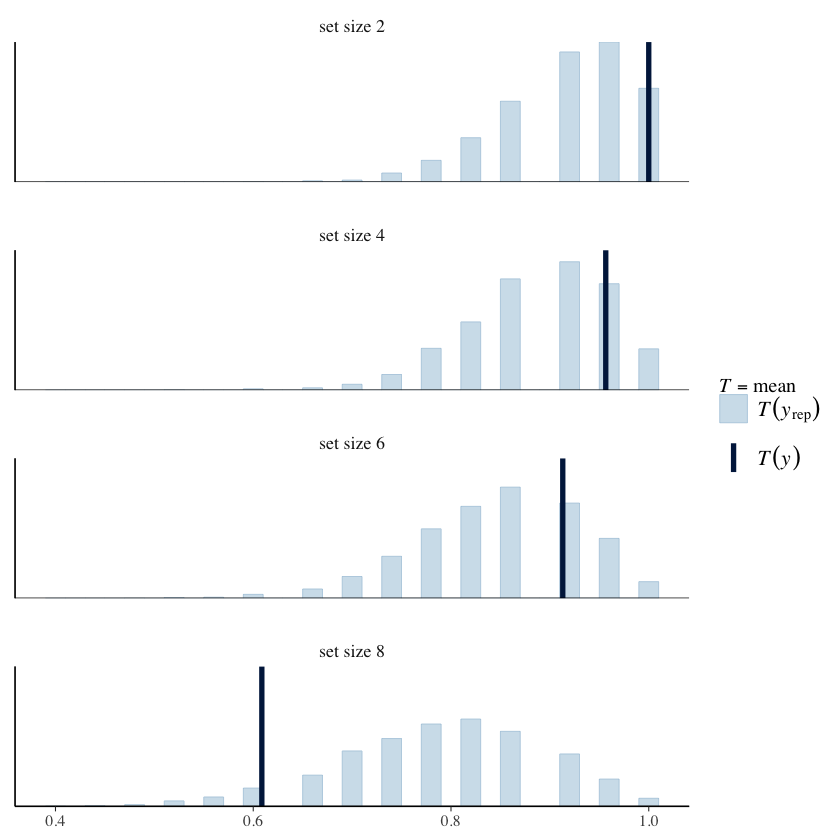

In [147]:
set_size <- paste("set size", c(2,4,6,8)) %>%
  setNames(c(-3,-1,1,3))

pp_check(fit_recall,
  type = "stat_grouped",
  stat = "mean",
  group = "c_set_size",
  binwidth = 0.02,
  facet_args = list(
    ncol = 1, 
    scales = "fixed",
    labeller = as_labeller(set_size)
  ),
)

One potentially useful aspect of posterior distributions is that we could also make predictions for other conditions not presented in the actual experiment, such as set sizes that weren’t tested. We could then investigate whether our model was right using another experiment. To make predictions for other set sizes, we extend our data set, adding rows with set sizes of 3, 5, and 7.

In [134]:
df_recall_ext <- df_recall %>%
  bind_rows(tibble(
    set_size = rep(c(3, 5, 7), 23), # po 23 triale z każego warunku
    c_set_size = set_size -
      mean(df_recall$set_size),
    correct = 0
  ))

Using all posterior draws for ppc type 'stat_grouped' by default.



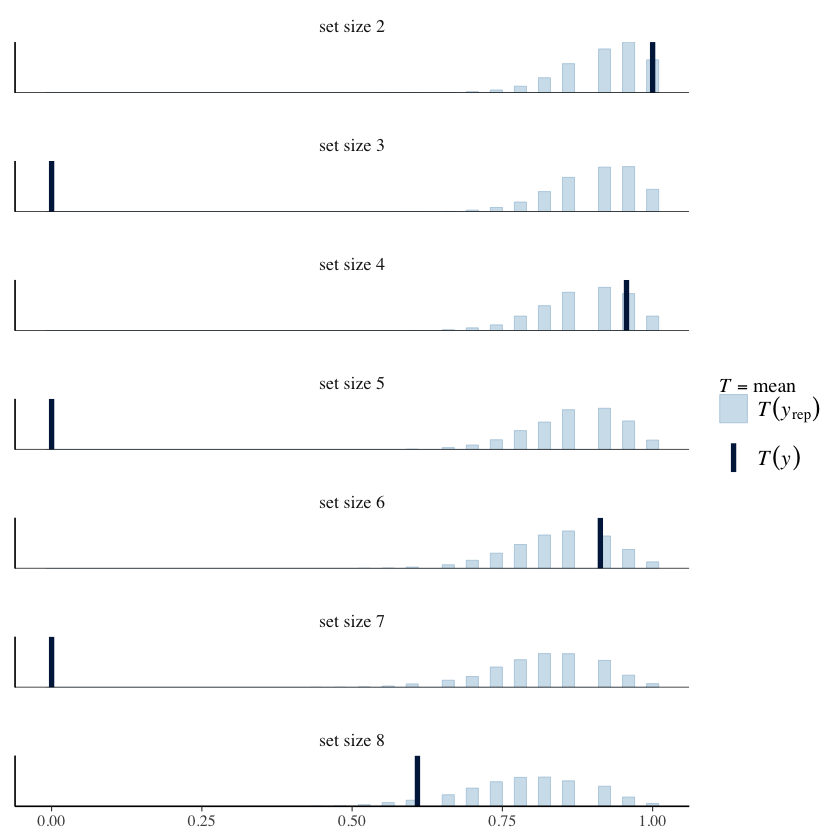

In [140]:
set_size <- paste("set size", 2:8) %>%
  setNames(-3:3)

pp_check(fit_recall,
  type = "stat_grouped",
  stat = "mean",
  group = "c_set_size",
  newdata = df_recall_ext,
  binwidth = 0.02,
  facet_args = list(
    ncol = 1, 
    scales = "fixed",
    labeller = as_labeller(set_size)
  ),
)

# Excercises

## 4.1

In [148]:
data("df_powerpose")
head(df_powerpose)

id hptreat female age testm1 testm2 
2 29 High    Male   19  38.725  62.375
3 30 Low     Female 20  32.770  29.235
4 31 High    Female 20  32.320  27.510
5 32 Low     Female 18  17.995  28.655
7 34 Low     Female 21  73.580  44.670
8 35 High    Female 20  80.695 105.485

The research hypothesis is that on average, assigning a subject a high power pose vs. a low power pose will lead to higher testosterone levels after treatment. Assuming that you know nothing about normal ranges of testosterone using salivary measurement, choose an appropriate Cauchy prior (e.g., Cauchy(2.5)) for the target parameter(s).

In [149]:
df_powerpose <- mutate(df_powerpose, change = testm2 - testm1)

In [150]:
head(df_powerpose)

id hptreat female age testm1 testm2  change    
2 29 High    Male   19  38.725  62.375  23.650002
3 30 Low     Female 20  32.770  29.235  -3.534999
4 31 High    Female 20  32.320  27.510  -4.810000
5 32 Low     Female 18  17.995  28.655  10.660000
7 34 Low     Female 21  73.580  44.670 -28.910004
8 35 High    Female 20  80.695 105.485  24.790000

In [ ]:
fit_testm <- brm(change ~ hptreat,
                 data = df_powerpose,
                )

In [157]:
fit_testm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: change ~ 1 + hptreat 
   Data: df_powerpose (Number of observations: 39) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      4.18      4.60    -5.21    13.40 1.00     4146     3028
hptreatLow    -8.68      6.58   -21.31     4.50 1.00     3956     3060

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    20.51      2.43    16.48    26.03 1.00     3274     2489

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [153]:
prior_summary(fit_testm)

prior                    class     coef       group resp dpar nlpar lb ub
1                          b                                               
2                          b         hptreatLow                            
3 student_t(3, -1.9, 18.7) Intercept                                       
4 student_t(3, 0, 18.7)    sigma                                      0    
  source 
1 default
2 default
3 default
4 default

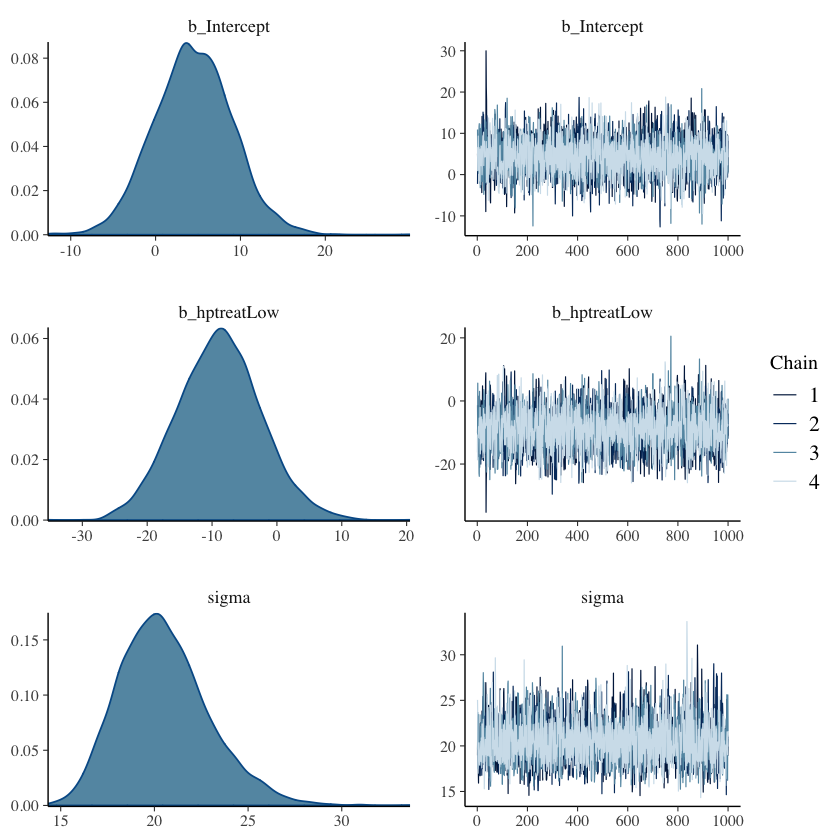

In [154]:
plot(fit_testm)

## 4.2

Another linear regression model: Revisiting attentional load effect on pupil size.

1. Our priors for this experiment were quite arbitrary. How do the prior predictive distributions look like? Do they make sense?

In [160]:
data("df_pupil")

In [ ]:
# centering data

data("df_pupil")
(df_pupil <- df_pupil %>%
  mutate(c_load = load - mean(load)))

In [ ]:
# prior predictive dist

fit_prior_pupil <- brm(p_size ~ 1 + c_load,
  data = df_pupil,
  family = gaussian(),
  prior = c(
    prior(normal(1000,500), class = Intercept),
    prior(normal(0,1000), class = sigma),
    prior(normal(0,100), class = b, coef = c_load) 
  ),
  sample_prior = "only",
  # control = list(adapt_delta = .9),
)

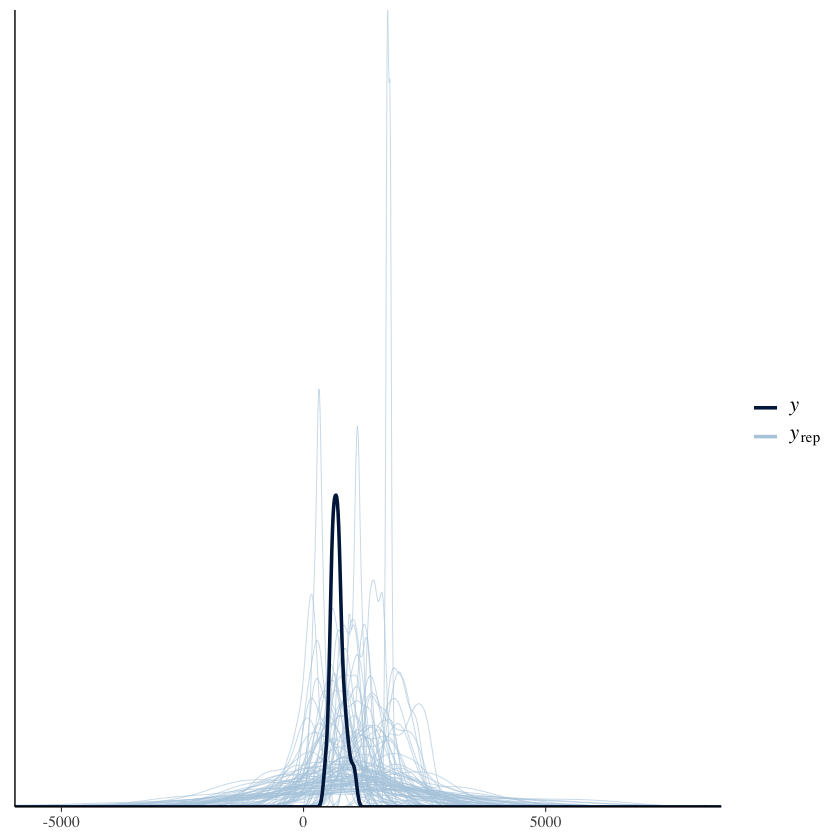

In [168]:
pp_check(
        fit_prior_pupil, 
        ndraws=100,
    ) 

Using all posterior draws for ppc type 'stat' by default.



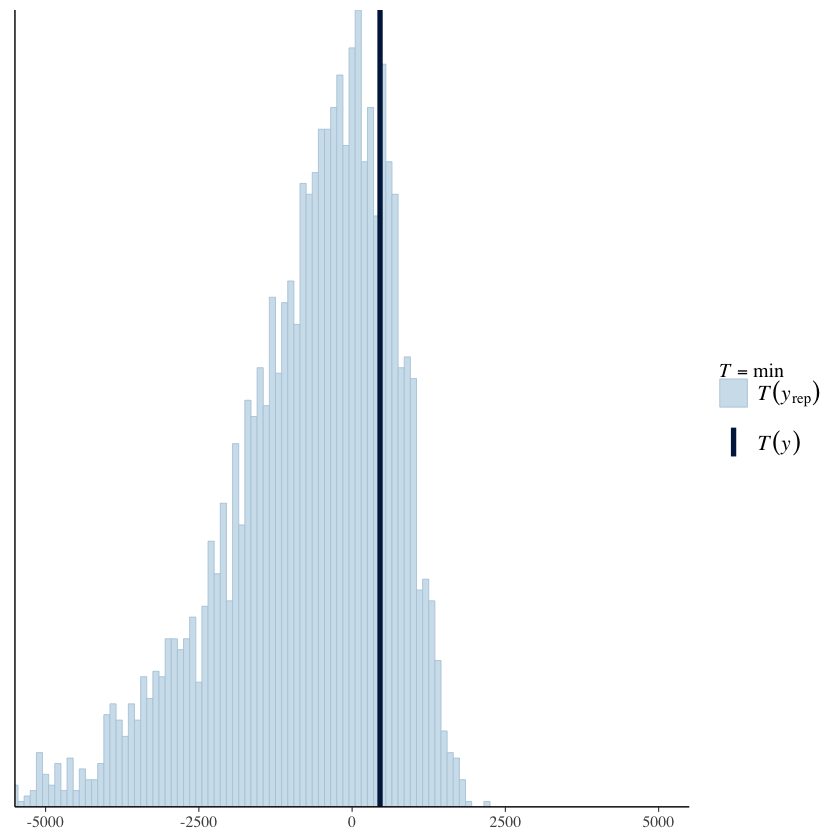

In [174]:
pp_check(
    fit_prior_pupil, 
    type = "stat",
    stat="min",
    binwidth = 100
    ) + coord_cartesian(xlim = c(-5000, 5000))

Pupil sizes sholdn't be negative! Let's check another prior

In [ ]:
fit_prior_pupil <- brm(p_size ~ 1 + c_load,
  data = df_pupil,
  family = gaussian(),
  prior = c(
    prior(normal(1000,500), class = Intercept),
    prior(normal(100,50), class = sigma),
    prior(normal(0,100), class = b, coef = c_load) 
  ),
  sample_prior = "only",
  # control = list(adapt_delta = .9),
)

Using all posterior draws for ppc type 'stat' by default.



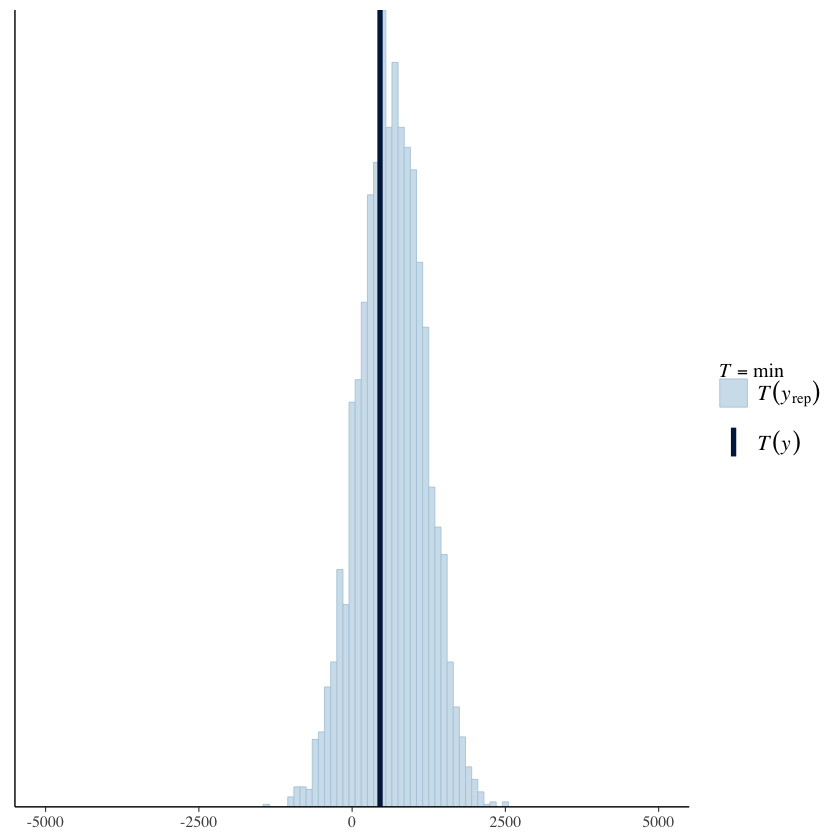

In [176]:
pp_check(
    fit_prior_pupil, 
    type = "stat",
    stat="min",
    binwidth = 100
    ) + coord_cartesian(xlim = c(-5000, 5000))

Seems better!

2. Is our posterior distribution sensitive to the priors that we selected? Perform a sensitivity analysis to find out whether the posterior is affected by our choice of prior for the σ.

In [178]:
# fit 1

fit_pupil_1 <- brm(p_size ~ 1 + c_load,
  data = df_pupil,
  family = gaussian(),
  prior = c(
    prior(normal(1000,500), class = Intercept),
    prior(normal(0,1000), class = sigma),
    prior(normal(0,100), class = b, coef = c_load) 
  ),
)

fit_pupil_1

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '85e3c388042a97a109234aaf8b1ba52b' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.07704 seconds (Warm-up)
Chain 1:                0.017165 seconds (Sampling)
C

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: p_size ~ 1 + c_load 
   Data: df_pupil (Number of observations: 41) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   701.30     20.61   660.76   741.83 1.00     3450     2677
c_load       33.61     12.18     9.96    57.82 1.00     3181     2334

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma   128.22     14.97   102.49   162.01 1.00     3070     2213

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [179]:
# fit 2

fit_pupil_2 <- brm(p_size ~ 1 + c_load,
  data = df_pupil,
  family = gaussian(),
  prior = c(
    prior(normal(1000,500), class = Intercept),
    prior(normal(100,50), class = sigma),
    prior(normal(0,100), class = b, coef = c_load) 
  ),
)

fit_pupil_2

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '72fcb6d4189b919c2980a5a87ebc9891' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.077049 seconds (Warm-up)
Chain 1:                0.015819 seconds (Sampling)


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: p_size ~ 1 + c_load 
   Data: df_pupil (Number of observations: 41) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   701.52     19.42   663.46   739.85 1.00     3490     2698
c_load       33.92     11.75    10.35    56.67 1.00     2836     2622

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma   126.13     14.00   102.64   156.80 1.00     3215     2673

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

3. Our data set includes also a column that indicates the trial number. Could it be that trial has also an effect on the pupil size? As in lm, we indicate another main effect with a + sign. How would you communicate the new results?

In [190]:
# center trial variable

df_pupil <- df_pupil %>%
  mutate(c_trial = trial - mean(trial))

df_pupil <- df_pupil %>%
  mutate(c_load = load - mean(load))

In [ ]:
fit_pupil_trial <- brm(p_size ~ 1 + c_load + c_trial,
  data = df_pupil,
  family = gaussian(),
  prior = c(
    prior(normal(1000,500), class = Intercept),
    prior(normal(0,1000), class = sigma),
    prior(normal(0,100), class = b, coef = c_load),
    prior(normal(0,100), class = b, coef = c_trial) 

  ),
)

In [194]:
fit_pupil_trial

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: p_size ~ 1 + c_load + c_trial 
   Data: df_pupil (Number of observations: 41) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   701.23     17.39   667.64   736.02 1.00     4319     2935
c_load       31.91     10.42    11.11    53.25 1.00     4426     2796
c_trial      -5.50      1.45    -8.34    -2.71 1.00     4439     2870

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma   110.06     12.87    87.73   138.07 1.00     3621     2878

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

The summary of the posterior tells us that the most likely values of the eﬀect of load will be around the mean of the posterior, 31.85, and we can be 95% certain that the true value of the eﬀect of load (given the model and the data) lies between 11.42 and 51.2. As before, as load increases the pupil size increases. The mean of the posterior for the eﬀect of trial will be -5.54, with a 95% credible interval of [−8.53, −2.69]; this is telling us that as the trials proceed further, the pupil size is reduced.

## 4.3

Log-normal model: Revisiting the effect of trial on response times.
We continue considering the effect of trial on response times.

1. Estimate the slowdown in milliseconds between the last two times the subject pressed the space bar in the experiment.

In [195]:
last_trial = max(df_spacebar$c_trial) # get number of last trial in centered trials values
pre_last_trial = last_trial - 1 # get number of pre- last trial in centered trials values

newdata_1 <- data.frame(c_trial = c(last_trial, pre_last_trial))

In [197]:
ending <- fitted(
    fit_press_trial,
    newdata = newdata_1,
    summary = FALSE)

[,1]     [,2]    
[1,] 189.4147 189.3001
[2,] 186.8862 186.7746
[3,] 183.8739 183.7916
[4,] 186.1922 186.0834
[5,] 185.0846 184.9781
[6,] 186.6716 186.5715

In [198]:
effect_ending_ms <- ending[, 1] - ending[,2]

c(
  mean = mean(effect_ending_ms),
  quantile(effect_ending_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.09689675 0.07249575 0.12147698

2. How would you change your model (keeping the log-normal likelihood) so that it includes centered log-transformed trial numbers or square-root-transformed trial numbers (instead of centered trial numbers)? Does the effect in milliseconds change?

In [202]:
df_spacebar <- df_spacebar %>%
  mutate(
      c_log_trial = log(trial) - mean(log(trial)),
      c_sqrt_trial = sqrt(trial) - mean(sqrt(trial))
  )

In [203]:
head(df_spacebar)

rt  trial c_trial c_log_trial c_sqrt_trial
1 141 1     -180    -4.899580   -11.69241   
2 138 2     -179    -4.206433   -11.27820   
3 128 3     -178    -3.800968   -10.96036   
4 132 4     -177    -3.513286   -10.69241   
5 126 5     -176    -3.290143   -10.45634   
6 134 6     -175    -3.107821   -10.24292

In [ ]:
# model for lof-trial
# sigma and Intercept are ok, but we have to change priors for B, as the variables are log transformed

fit_press_log_trial <- brm(rt ~ 1 + c_log_trial,
  data = df_spacebar,
  family = lognormal(),
  prior = c(
    prior(normal(6, 1.5), class = Intercept),
    prior(normal(0, 1), class = sigma),
    prior(normal(0, 1), class = b, coef = c_log_trial)
  ),
)

In [206]:
fit_press_log_trial

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ 1 + c_log_trial 
   Data: df_spacebar (Number of observations: 361) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       5.12      0.01     5.11     5.13 1.00     3938     3050
c_log_trial     0.06      0.01     0.05     0.08 1.00     4156     2852

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.12      0.00     0.11     0.13 1.00     3444     2922

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [213]:
# effect on the middle trial

middle_log <- df_spacebar %>% 
    filter(c_trial == 0) %>% 
    pull(c_log_trial) 

middle_m1_log <- df_spacebar %>% 
    filter(c_trial == -1) %>% 
    pull(c_log_trial)

middle_log
middle_m1_log

newdata_1 <- data.frame(c_log_trial = c(middle_log, middle_m1_log))

[1] 0.2989166

[1] 0.2933764

In [215]:
mid_log <- fitted(
    fit_press_log_trial,
    newdata = newdata_1,
    summary = FALSE)

In [216]:
effect_mid_log_ms <- mid_log[, 1] - mid_log[,2]

c(
  mean = mean(effect_mid_log_ms),
  quantile(effect_mid_log_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.05939276 0.04728195 0.07146268

In [217]:
alpha_samples <- as_draws_df(fit_press_log_trial)$b_Intercept 
beta_samples <- as_draws_df(fit_press_log_trial)$b_c_log_trial 

effect_middle_ms <- exp(alpha_samples + middle_log * beta_samples) -
    exp(alpha_samples + middle_m1_log * beta_samples) 

c(
    mean = mean(effect_middle_ms), 
    quantile(effect_middle_ms, c(.025, .975))
)

mean       2.5%      97.5% 
0.05896276 0.04694558 0.07095138

In [ ]:
# model for sqrt-trial
# sigma and Intercept are ok, but we have to change priors for B, as the variables are log transformed

fit_press_sqrt_trial <- brm(rt ~ 1 + c_sqrt_trial,
  data = df_spacebar,
  family = lognormal(),
  prior = c(
    prior(normal(6, 1.5), class = Intercept),
    prior(normal(0, 1), class = sigma),
    prior(normal(0, 1), class = b, coef = c_sqrt_trial)
  ),
)

In [219]:
fit_press_sqrt_trial

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ 1 + c_sqrt_trial 
   Data: df_spacebar (Number of observations: 361) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        5.12      0.01     5.11     5.13 1.00     2590     2306
c_sqrt_trial     0.01      0.00     0.01     0.02 1.00     4942     3249

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.12      0.00     0.11     0.13 1.00     2194     2287

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [222]:
# effect on the middle trial

middle_sqrt <- df_spacebar %>% 
    filter(c_trial == 0) %>% 
    pull(c_sqrt_trial) 

middle_m1_sqrt <- df_spacebar %>% 
    filter(c_trial == -1) %>% 
    pull(c_sqrt_trial)

newdata_1 <- data.frame(c_sqrt_trial = c(middle_sqrt, middle_m1_sqrt))

In [223]:
mid_sqrt <- fitted(
    fit_press_sqrt_trial,
    newdata = newdata_1,
    summary = FALSE)

In [224]:
effect_sqrt_log_ms <- mid_sqrt[, 1] - mid_sqrt[,2]

c(
  mean = mean(effect_sqrt_log_ms),
  quantile(effect_sqrt_log_ms, c(0.025, 0.975))
)

mean       2.5%      97.5% 
0.08313900 0.06458355 0.10118987

In [225]:
# todo - chars

## 4.4

In [227]:
head(df_recall)

subj set_size correct trial session block tested
1 10   4        1        1    1       1     2     
2 10   8        0        4    1       1     8     
3 10   2        1        9    1       1     2     
4 10   6        1       23    1       1     2     
5 10   4        1        5    1       2     3     
6 10   8        0        7    1       2     5

In [228]:
# center data - set_size
df_recall <- df_recall %>%
  mutate(
      c_set_size = set_size - mean(set_size),
      c_tested = tested - mean(tested)
  )

In [229]:
head(df_recall)

subj set_size correct trial session block tested c_set_size c_tested   
1 10   4        1        1    1       1     2      -1         -0.97826087
2 10   8        0        4    1       1     8       3          5.02173913
3 10   2        1        9    1       1     2      -3         -0.97826087
4 10   6        1       23    1       1     2       1         -0.97826087
5 10   4        1        5    1       2     3      -1          0.02173913
6 10   8        0        7    1       2     5       3          2.02173913

In [ ]:
fit_recall <- brm(correct ~ 1 + c_set_size + c_tested,
  data = df_recall,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .1), class = b, coef = c_set_size),
    prior(normal(0, .1), class = b, coef = c_tested)

  )
)

In [232]:
fit_recall

 Family: bernoulli 
  Links: mu = logit 
Formula: correct ~ 1 + c_set_size + c_tested 
   Data: df_recall (Number of observations: 92) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      1.94      0.31     1.36     2.58 1.00     3466     2853
c_set_size    -0.18      0.08    -0.34    -0.02 1.00     3082     2886
c_tested      -0.03      0.08    -0.20     0.13 1.00     2948     2877

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

**It seems that tested has no effect on recall accuracy**

## 4.5

Using logistic regressions, fit three different models to investigate whether being ovulating increases the probability of wearing (a) red, (b) pink, or (c) either pink or red. Use priors that are reasonable (in your opinion).

In [233]:
data("df_red")
head(df_red)

risk age red pink redorpink
8  0    19  0   0    0        
9  0    25  0   0    0        
10 0    20  0   0    0        
11 0    20  0   0    0        
14 0    20  0   0    0        
15 0    18  0   0    0

In [242]:
summary(df_red)

      risk             age             red               pink       
 Min.   :0.0000   Min.   :17.00   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:20.00   1st Qu.:0.00000   1st Qu.:0.0000  
 Median :0.0000   Median :25.00   Median :0.00000   Median :0.0000  
 Mean   :0.4919   Mean   :25.59   Mean   :0.06452   Mean   :0.1129  
 3rd Qu.:1.0000   3rd Qu.:29.25   3rd Qu.:0.00000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :47.00   Max.   :1.00000   Max.   :1.0000  
   redorpink     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.1774  
 3rd Qu.:0.0000  
 Max.   :1.0000  

### Priors

In [ ]:
# alpha
# average risk is .5 (a 50/50 chance) with a great deal of uncertainty - so norm(0,SD)
# SD of 1.5 from previous excercises was good

# alpha = norm(0,1.5)


# beta


In [240]:
logistic_model_pred <- function(alpha_samples,
                                beta_samples,
                                risk,
                                N_obs) {
  map2_dfr(alpha_samples, beta_samples,
    function(alpha, beta) {
      tibble(
        risk = risk,
        # change the likelihood:
        # Notice the use of a link function
        # for alpha and beta
        theta = plogis(alpha + risk * beta),
        red_pred = rbernoulli(N_obs, p = theta)
      )
    },
    .id = "iter"
  ) %>%
    # .id is always a string and needs
    # to be converted to a number
    mutate(iter = as.numeric(iter))
}

In [243]:
N_obs <- 124
risk <- rep(c(0,1), 62)

In [251]:
alpha_samples <- rnorm(1000, 0, 1.5)
sds_beta <- c(10, 1, 0.5, 0.1, 0.01, 0.001, 000001)

prior_pred <- map_dfr(sds_beta, function(sd) {
  beta_samples <- rnorm(1000, 0, sd)
  logistic_model_pred(
    alpha_samples = alpha_samples,
    beta_samples = beta_samples,
    risk = risk,
    N_obs = N_obs
  ) %>%
    mutate(prior_beta_sd = sd)
})

In [252]:
mean_accuracy <-
  prior_pred %>%
  group_by(prior_beta_sd, iter, risk) %>%
  summarize(accuracy = mean(red_pred)) %>%
  mutate(prior = paste0("Normal(0, ", prior_beta_sd, ")"))

`summarise()` has grouped output by 'prior_beta_sd', 'iter'. You can override using the `.groups` argument.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



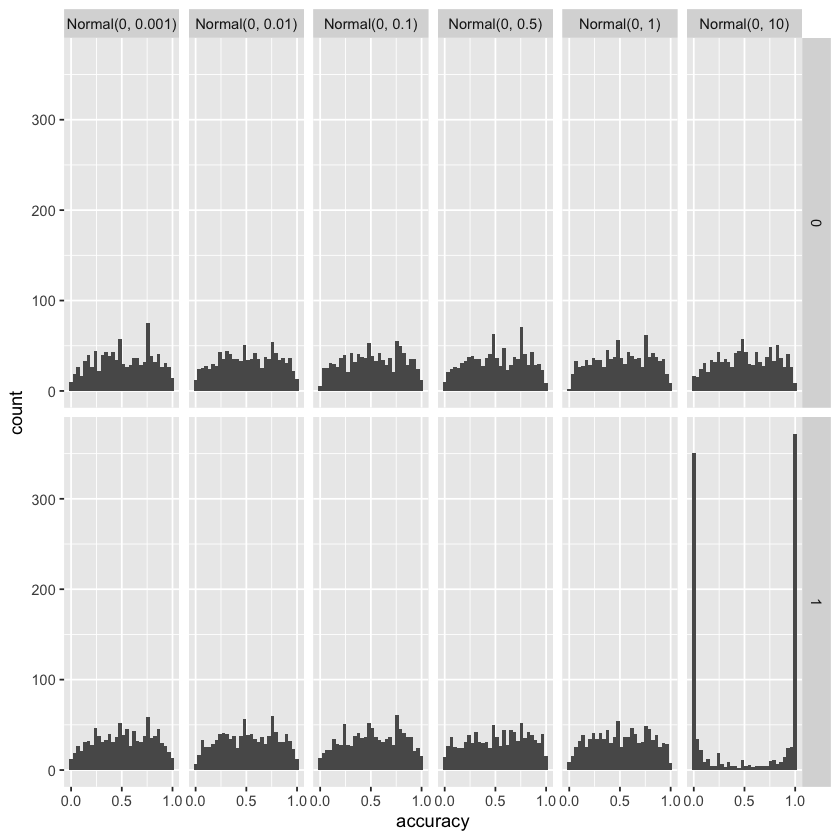

In [253]:
mean_accuracy %>%
  ggplot(aes(accuracy)) +
  geom_histogram() +
  facet_grid(risk ~ prior) +
  scale_x_continuous(breaks = c(0, .5, 1))

### Models

In [ ]:
fit_risk_red <- brm(red ~ 1 + risk,
  data = df_red,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .1), class = b, coef = risk)
  )
)

In [ ]:
fit_risk_red <- brm(red ~ 1 + risk,
  data = df_red,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .5), class = b, coef = risk)
  )
)

In [235]:
fit_risk_red

 Family: bernoulli 
  Links: mu = logit 
Formula: red ~ 1 + risk 
   Data: df_red (Number of observations: 124) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -2.59      0.35    -3.31    -1.94 1.00     2965     2319
risk          0.02      0.10    -0.18     0.22 1.00     3357     2793

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

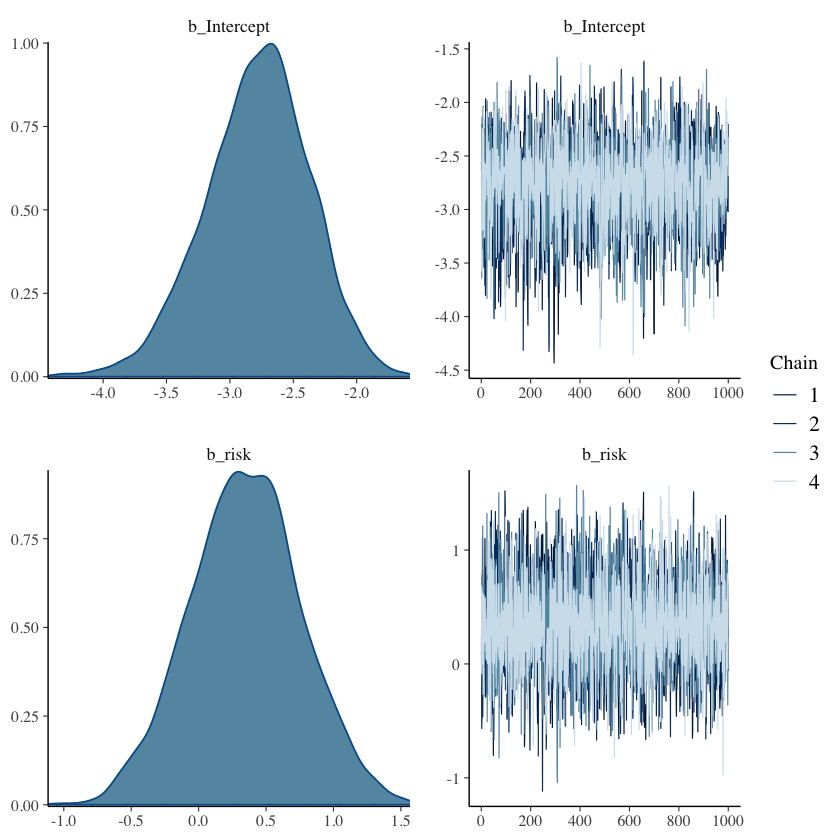

In [249]:
plot(fit_risk_red)

In [ ]:
fit_risk_pink <- brm(pink ~ 1 + risk,
  data = df_red,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .1), class = b, coef = risk)
  )
)

In [237]:
fit_risk_pink

 Family: bernoulli 
  Links: mu = logit 
Formula: pink ~ 1 + risk 
   Data: df_red (Number of observations: 124) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -2.04      0.29    -2.64    -1.50 1.00     3528     2437
risk          0.04      0.10    -0.16     0.24 1.00     3410     2106

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [ ]:
fit_risk_redorpink <- brm(redorpink ~ 1 + risk,
  data = df_red,
  family = bernoulli(link = logit),
  prior = c(
    prior(normal(0, 1.5), class = Intercept),
    prior(normal(0, .1), class = b, coef = risk)
  )
)

In [239]:
fit_risk_redorpink

 Family: bernoulli 
  Links: mu = logit 
Formula: redorpink ~ 1 + risk 
   Data: df_red (Number of observations: 124) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.55      0.24    -2.04    -1.10 1.00     3227     2767
risk          0.06      0.10    -0.13     0.25 1.00     3716     2900

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

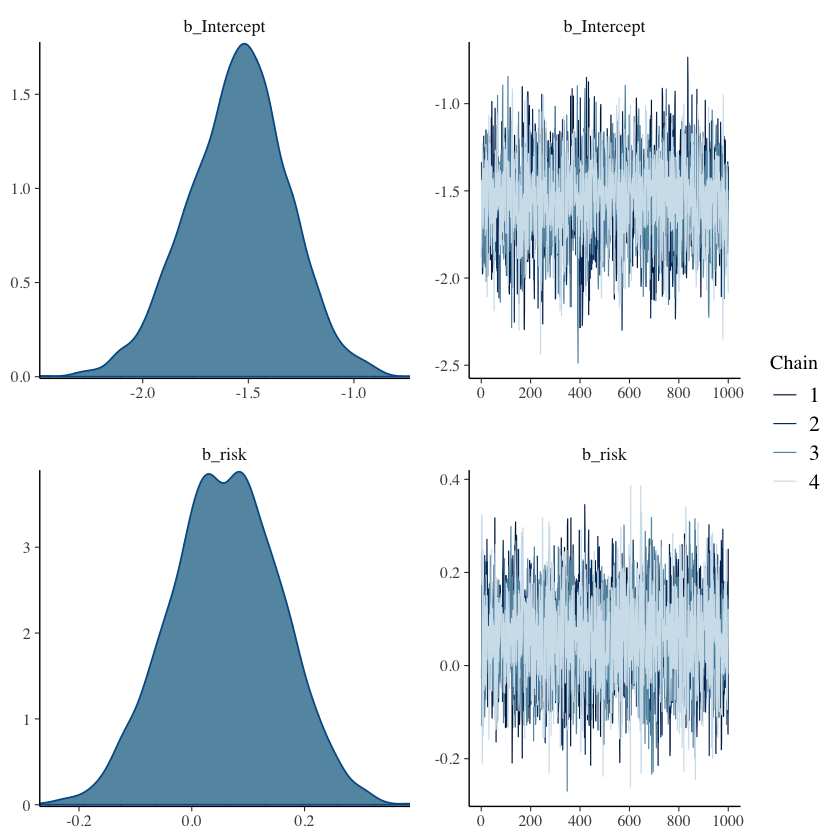

In [250]:
plot(fit_risk_redorpink)